# Modélisation

## Prédiction énergie

In [1]:
import pandas as pd
import numpy as np
import json as js
import seaborn as sn
import matplotlib.pyplot as plt
import ast
np.random.seed(13) # résultats reproductibles

In [2]:
mydf = pd.read_csv('mydf.csv')
tar = pd.read_csv('tar.csv')
pd.set_option('display.max_columns', None)

In [3]:
mydf.head()

,BuildingType_Campus,BuildingType_NonResidential,BuildingType_SPS-District K-12,LargestPropertyUseType_Adult Education,LargestPropertyUseType_Automobile Dealership,LargestPropertyUseType_Bank Branch,LargestPropertyUseType_College/University,LargestPropertyUseType_Convention Center,LargestPropertyUseType_Courthouse,LargestPropertyUseType_Data Center,LargestPropertyUseType_Distribution Center,LargestPropertyUseType_Financial Office,LargestPropertyUseType_Fire Station,LargestPropertyUseType_Fitness Center/Health Club/Gym,LargestPropertyUseType_Food Service,LargestPropertyUseType_Hospital (General Medical & Surgical),LargestPropertyUseType_Hotel,LargestPropertyUseType_K-12 School,LargestPropertyUseType_Laboratory,LargestPropertyUseType_Library,LargestPropertyUseType_Lifestyle Center,LargestPropertyUseType_Manufacturing/Industrial Plant,LargestPropertyUseType_Medical Office,LargestPropertyUseType_Movie Theater,LargestPropertyUseType_Museum,LargestPropertyUseType_Non-Refrigerated Warehouse,LargestPropertyUseType_Office,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Education,LargestPropertyUseType_Other - Entertainment/Public Assembly,LargestPropertyUseType_Other - Lodging/Residential,LargestPropertyUseType_Other - Mall,LargestPropertyUseType_Other - Public Services,LargestPropertyUseType_Other - Recreation,LargestPropertyUseType_Other - Restaurant/Bar,LargestPropertyUseType_Other - Services,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Other/Specialty Hospital,LargestPropertyUseType_Outpatient Rehabilitation/Physical Therapy,LargestPropertyUseType_Parking,LargestPropertyUseType_Performing Arts,"LargestPropertyUseType_Personal Services (Health/Beauty, Dry Cleaning, etc)",LargestPropertyUseType_Police Station,LargestPropertyUseType_Pre-school/Daycare,LargestPropertyUseType_Prison/Incarceration,LargestPropertyUseType_Refrigerated Warehouse,"LargestPropertyUseType_Repair Services (Vehicle, Shoe, Locksmith, etc)",LargestPropertyUseType_Residence Hall/Dormitory,LargestPropertyUseType_Residential Care Facility,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Unknown,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Wholesale Club/Supercenter,LargestPropertyUseType_Worship Facility,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater Duwamish,Neighborhood_Lake Union,Neighborhood_Magnolia / Queen Anne,Neighborhood_North,Neighborhood_Northeast,Neighborhood_Northwest,Neighborhood_Southeast,Neighborhood_Southwest,PrimaryPropertyType_College/University,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Non-Refrigerated Warehouse,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall/Dormitory,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket/Grocery Store,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,BuildingAge,NumberofBuildings,PropertyGFATotal,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,ENERGYSTARScore
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,1.0,43813,20727,23086,45145.0,76.000000


In [4]:
tar.head()

,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e)
0,1798899.0,12.54
1,282898.0,1.97
2,3816695.0,119.01
3,24126.0,0.17
4,413919.0,4.43


In [5]:
comparative_ele = pd.DataFrame(columns=['model','tuning','data_dimension','mse','mae','r2','training_score','testing_score'])
comparative_co2 = pd.DataFrame(columns=['model','tuning','data_dimension','mse','mae','r2','training_score','testing_score'])
comparative_co2_ess = pd.DataFrame(columns=['model','tuning','data_dimension','mse','mae','r2','training_score','testing_score'])
comparative_co2_ess2 = pd.DataFrame(columns=['model','tuning','data_dimension','mse','mae','r2','training_score','testing_score'])

#### Séparation du jeu de données

In [6]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV

In [7]:
tar = tar.fillna(tar.mean())

In [8]:
mydf.isna().values.any()

False

### ACP 1D pour visualisation

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from time import time

x = StandardScaler().fit_transform(mydf)
x = pd.DataFrame(x,columns=mydf.columns)

    # Pour la visualisation
pca = PCA(n_components=1)
x1d = pca.fit_transform(x)
x1d = pd.DataFrame(x1d,columns=['PC1'])


In [10]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNet
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.pipeline import make_pipeline

In [11]:
print('Méthode: LinearRegression\n')

t0=time()
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
solver = ['auto','svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
param_grid = dict(alpha=alpha, solver=solver)

col = 'SiteEnergyUse(kBtu)'
X_train, X_test, y_train, y_test = train_test_split(x1d, tar[col], test_size=0.2)

Méthode: LinearRegression



#### GridSearch CrossValidation - Modèles linéaires

In [12]:
grid = GridSearchCV(estimator=Ridge(), param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, y_train)
print('')
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('')

ridge1d_gs = Ridge(alpha=grid_result.best_params_['alpha']).fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits

Best Score:  0.3624547015254421
Best Params:  {'alpha': 100, 'solver': 'sag'}



In [13]:
y_pred_train = ridge1d_gs.predict(X_train)
y_pred = ridge1d_gs.predict(X_test)


r1d_r2 = r2_score(y_test,y_pred)
r1d_mse = mean_squared_error(y_test,y_pred)
r1d_mae = mean_absolute_error(y_test,y_pred)
r1d_test = ridge1d_gs.score(X_test, y_test)
r1d_train = ridge1d_gs.score(X_train,y_train)
print('Prédiction de ',col)
print('\tscore d\'entrainement = ', r1d_train)
print("\tscore de la prédiction: ",  r1d_test), 
print("\tMAE = ", r1d_mae)
print("\tMSE = ", r1d_mse)


print('\n----------------------------------------------\n')
t1=time()
print("processing time : ",t1-t0)



Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.2958126584725451
	score de la prédiction:  0.42890040884181957
	MAE =  7590239.850186802
	MSE =  370168871620692.75

----------------------------------------------

processing time :  2.2899973392486572


In [14]:
row = {'model':'Ridge','tuning':'gridsearch', 'data_dimension':x1d.shape[1], 'mse':r1d_mse, 'mae':r1d_mae, 'r2':r1d_r2, 'training_score':r1d_train, 'testing_score':r1d_test}
comparative_ele = comparative_ele.append(row, ignore_index=True)

In [15]:
comparative_ele

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,gridsearch,1,3.701689e+14,7.590240e+06,0.4289,0.295813,0.4289


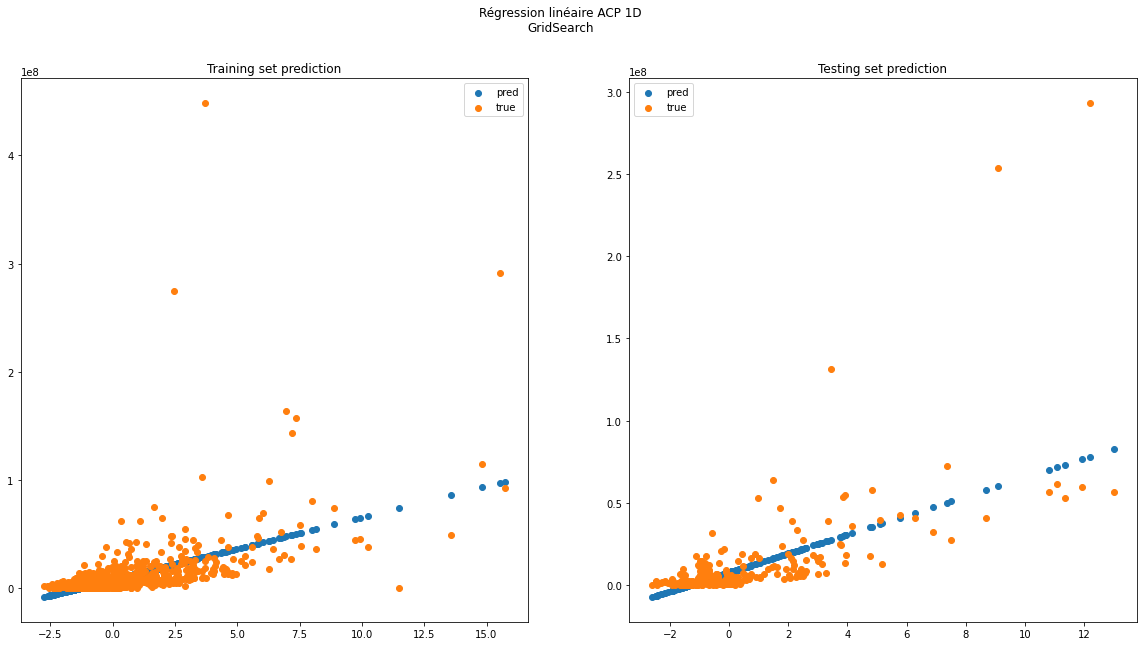

In [16]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
plt.suptitle("Régression linéaire ACP 1D\nGridSearch")
ax[0].set_title("Training set prediction")
ax[0].scatter(X_train,y_pred_train,label='pred')
ax[0].scatter(X_train, y_train,label='true')
ax[0].legend()
ax[1].set_title("Testing set prediction")
ax[1].scatter(X_test,y_pred,label='pred')
ax[1].scatter(X_test, y_test,label='true')
ax[1].legend()

In [17]:
from sklearn.svm import SVR
t0 = time()

In [18]:
C = [0.1, 1, 10]
eps = [0.1,  0.2, 0.5]
kernel = ['poly','rbf', 'sigmoid']
deg = [3,4,5]

param_grid = dict(C=C, kernel = kernel, degree=deg, epsilon=eps)

X_train, X_test, y_train, y_test = train_test_split(x1d, tar[col], test_size=0.2)

In [19]:
## warning très long

grid = GridSearchCV(estimator=SVR(), param_grid=param_grid, scoring='r2', verbose=1, cv=5)
grid_result = grid.fit(X_train, y_train)
print('Méthode: SVR\n')
print('')
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Méthode: SVR


Best Score:  0.12112167715210245
Best Params:  {'C': 10, 'degree': 4, 'epsilon': 0.1, 'kernel': 'poly'}



In [20]:
svr1d_gs = SVR(
            C=grid_result.best_params_['C'], 
            kernel=grid_result.best_params_['kernel'],
            degree=grid_result.best_params_['degree'],
            epsilon=grid_result.best_params_['epsilon'],
           ).fit(X_train, y_train)

In [21]:
y_pred_train = svr1d_gs.predict(X_train)
y_pred = svr1d_gs.predict(X_test)

svr1d_r2 = r2_score(y_test,y_pred)
svr1d_mse = mean_squared_error(y_test,y_pred)
svr1d_mae = mean_absolute_error(y_test,y_pred)
svr1d_test = svr1d_gs.score(X_test, y_test)
svr1d_train = svr1d_gs.score(X_train,y_train)
print('Prédiction de ',col)
print('\tscore d\'entrainement = ', svr1d_train)
print("\tscore de la prédiction: ",  svr1d_test), 
print("\tMAE = ", svr1d_mae)
print("\tMSE = ", svr1d_mse)


print('\n----------------------------------------------\n')
t1=time()
print("processing time : ",t1-t0)

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.15461650268906957
	score de la prédiction:  -0.005347040829345451
	MAE =  6137284.869133633
	MSE =  389024327819053.0

----------------------------------------------

processing time :  28.6619975566864


In [22]:
row = {'model':'SVR', 'tuning':'gridsearch', 'data_dimension':x1d.shape[1], 'mse':svr1d_mse, 'mae':svr1d_mae,'r2':svr1d_r2, 'training_score':svr1d_train, 'testing_score':svr1d_test}
comparative_ele = comparative_ele.append(row,ignore_index=True)
t1 = time()
print("\ncomputation time : ",t1-t0)


computation time :  28.68199849128723


In [23]:
comparative_ele

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,gridsearch,1,3.701689e+14,7.590240e+06,0.428900,0.295813,0.428900
1,SVR,gridsearch,1,3.890243e+14,6.137285e+06,-0.005347,0.154617,-0.005347


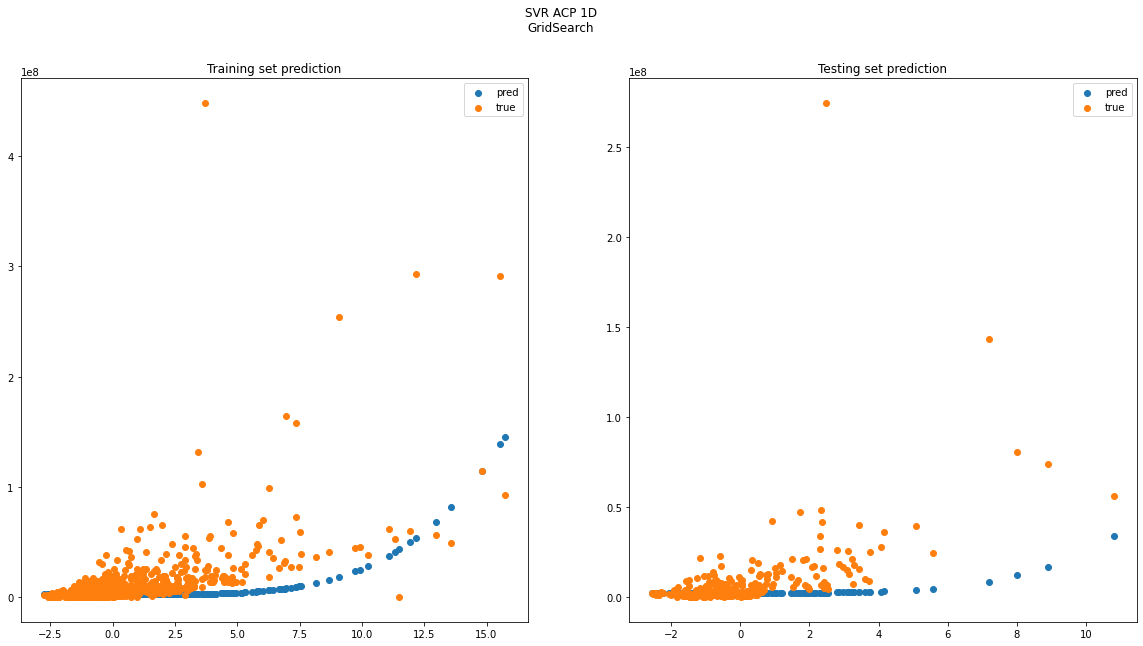

In [24]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
plt.suptitle("SVR ACP 1D\nGridSearch")
ax[0].set_title("Training set prediction")
ax[0].scatter(X_train,y_pred_train,label='pred')
ax[0].scatter(X_train, y_train,label='true')
ax[0].legend()
ax[1].set_title("Testing set prediction")
ax[1].scatter(X_test,y_pred,label='pred')
ax[1].scatter(X_test, y_test,label='true')
ax[1].legend()

#### RandomSearch CrossValidation

In [25]:
from sklearn.model_selection import RandomizedSearchCV as rscv
from scipy.stats import uniform

##### SVR

In [26]:
X_train, X_test, y_train, y_test = train_test_split(x1d, tar[col], test_size=0.2)

In [27]:
SVR().get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [28]:
dist = dict(C=uniform(loc=0, scale=1), degree=[2,3,5,7], 
            epsilon=uniform(loc=0, scale=1), 
            kernel = ['poly','rbf', 'sigmoid'],
            coef0=uniform(loc=-1,scale=1),
           )
clf = rscv(SVR(), dist, random_state=0)

In [29]:
## warning très long

t0 = time()
srch = clf.fit(X_train,y_train)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  3.3030288219451904


In [30]:
srch.best_params_

{'C': 0.38648898112586194,
 'coef0': -0.09740152447059536,
 'degree': 5,
 'epsilon': 0.359507900573786,
 'kernel': 'poly'}

In [31]:
svr_rs = SVR(
            C=srch.best_params_['C'], 
            kernel=srch.best_params_['kernel'],
            degree=srch.best_params_['degree'],
            epsilon=srch.best_params_['epsilon'],
            coef0 = srch.best_params_['coef0']
           )

In [32]:
y_pred_train = svr_rs.fit(X_train, y_train).predict(X_train)
y_pred = svr_rs.fit(X_train, y_train).predict(X_test)

svr_r2 = r2_score(y_test,y_pred)
svr_mse = mean_squared_error(y_test,y_pred)
svr_mae = mean_absolute_error(y_test,y_pred)
svr_test = svr_rs.score(X_test, y_test)
svr_train = svr_rs.score(X_train,y_train)
print('Prédiction de ',col)
print('\tscore d\'entrainement = ', svr_train)
print("\tscore de la prédiction: ",  svr_test), 
print("\tMAE = ", svr_mae)
print("\tMSE = ", svr_mse)


print('\n----------------------------------------------\n')
t1=time()
print("processing time : ",t1-t0)

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.09013456004708142
	score de la prédiction:  0.18852481091218098
	MAE =  6188418.284771778
	MSE =  318340546733615.56

----------------------------------------------

processing time :  3.597998857498169


In [33]:
row = {'model':'SVR', 'tuning':'randomsearch', 'data_dimension':x1d.shape[1], 'mse':svr_mse, 'mae':svr_mae, 'r2':svr_r2, 'training_score':svr_train, 'testing_score':svr_test}
comparative_ele = comparative_ele.append(row, ignore_index=True)

In [34]:
comparative_ele

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,gridsearch,1,3.701689e+14,7.590240e+06,0.428900,0.295813,0.428900
1,SVR,gridsearch,1,3.890243e+14,6.137285e+06,-0.005347,0.154617,-0.005347
2,SVR,randomsearch,1,3.183405e+14,6.188418e+06,0.188525,0.090135,0.188525


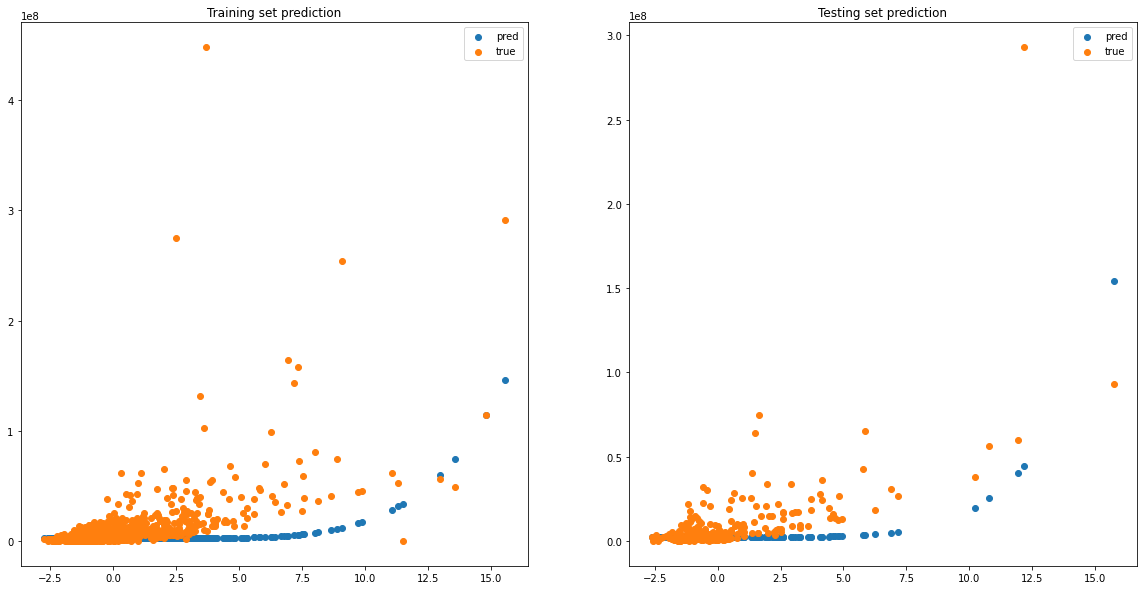

In [35]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_title("Training set prediction")
ax[0].scatter(X_train,y_pred_train,label='pred')
ax[0].scatter(X_train, y_train,label='true')
ax[0].legend()
ax[1].set_title("Testing set prediction")
ax[1].scatter(X_test,y_pred,label='pred')
ax[1].scatter(X_test, y_test,label='true')
ax[1].legend()

##### Kernel Ridge

In [36]:
from sklearn.kernel_ridge import KernelRidge

In [37]:
KernelRidge().get_params().keys()

dict_keys(['alpha', 'coef0', 'degree', 'gamma', 'kernel', 'kernel_params'])

In [38]:
dist = dict(alpha= uniform(loc=0, scale=10),
    kernel= ['additive_chi2', 'chi2', 'linear', 'poly', 'rbf', 'laplacian', 'sigmoid', 'cosine'],
    gamma= uniform(loc=-10,scale=10),
    degree= [1,2,3,4,5,6,7],
    coef0=uniform(loc=-10,scale=10)  
           )
clf = rscv(KernelRidge(), dist, random_state=0)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(x1d, tar[col], test_size=0.2)

In [40]:
t0 = time()
srch = clf.fit(X_train,y_train)

t1=time()
print("temps de calcul : ", t1-t0)

D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\kernel_ridge.py", line 172, in fit
    K = self._get_kernel(X)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\kernel_ridge.py", line 133, in _get_kernel
    return pairwise_kernels(X, Y, metric=self.kernel,
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\metrics\pairwise.py", line 1954, in pairwise_kerne

temps de calcul :  2.7149994373321533


D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-0.13728821         nan -8.24622804         nan         nan  0.37008893
         nan  0.18849737 -7.87208857  0.18852287]
  warnings.warn(


In [41]:
print(srch.best_params_)

{'alpha': 9.78618342232764, 'coef0': -2.0084143578327645, 'degree': 4, 'gamma': -4.795225204487952, 'kernel': 'poly'}


In [42]:
t0 = time()
kr_rs = KernelRidge(alpha=srch.best_params_['alpha'], 
            kernel=srch.best_params_['kernel'],
            degree=srch.best_params_['degree'],
            gamma=srch.best_params_['gamma'],
            coef0=srch.best_params_['coef0']
           )

y_pred_train = kr_rs.fit(X_train,y_train).predict(X_train)
y_pred = kr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.2590017318725586


In [43]:
kr_r2 = r2_score(y_test,y_pred)
kr_mse = mean_squared_error(y_test,y_pred)
kr_mae = mean_absolute_error(y_test,y_pred)
kr_test = kr_rs.score(X_test, y_test)
kr_train = kr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',kr_train)
print("\tscore de la prédiction: ",  kr_test), 
print("\tMAE = ", kr_mae)
print("\tMSE = ", kr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.37065676842783535
	score de la prédiction:  0.2730657737709825
	MAE =  4849322.593727503
	MSE =  77914595819524.89

----------------------------------------------



In [44]:
row = {'model':'KernelRidge', 'tuning':'randomsearch', 'data_dimension':x1d.shape[1], 'mse':kr_mse, 'mae':kr_mae, 'r2':kr_r2, 'training_score':kr_train, 'testing_score':kr_test}

In [45]:
comparative_ele = comparative_ele.append(row, ignore_index=True)

In [46]:
comparative_ele

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,gridsearch,1,3.701689e+14,7.590240e+06,0.428900,0.295813,0.428900
1,SVR,gridsearch,1,3.890243e+14,6.137285e+06,-0.005347,0.154617,-0.005347
2,SVR,randomsearch,1,3.183405e+14,6.188418e+06,0.188525,0.090135,0.188525
3,KernelRidge,randomsearch,1,7.791460e+13,4.849323e+06,0.273066,0.370657,0.273066


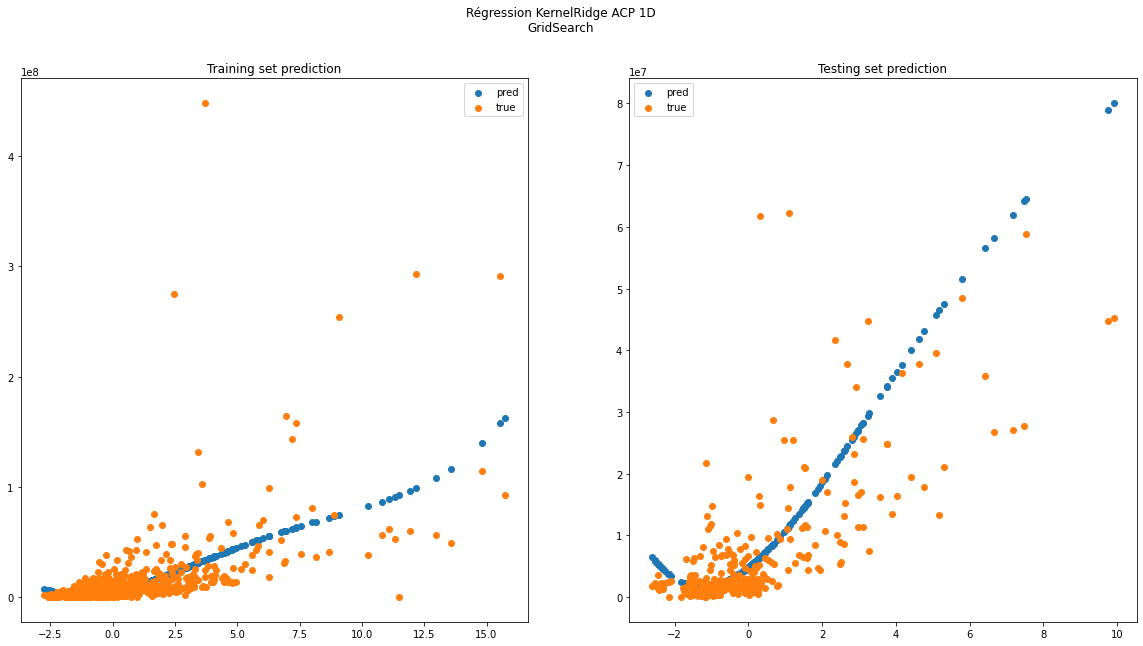

In [47]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
plt.suptitle("Régression KernelRidge ACP 1D\nGridSearch")
ax[0].set_title("Training set prediction")
ax[0].scatter(X_train,y_pred_train,label='pred')
ax[0].scatter(X_train, y_train,label='true')
ax[0].legend()
ax[1].set_title("Testing set prediction")
ax[1].scatter(X_test,y_pred,label='pred')
ax[1].scatter(X_test, y_test,label='true')
ax[1].legend()

##### Decision Tree

In [48]:
from sklearn.tree import DecisionTreeRegressor as DTR

In [49]:
DTR().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [50]:
dist = dict(
        ccp_alpha = uniform(loc=0,scale=5),
        criterion = ['mse', 'friedman_mse', 'mae', 'poisson'],
        splitter = ['best', 'random'],
        max_features = ['auto', 'sqrt', 'log2']
)
clf = rscv(DTR(), dist, random_state=0)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(x1d, tar[col], test_size=0.2)

In [52]:
t0 = time()
srch = clf.fit(X_train,y_train)

t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.3850259780883789


In [53]:
print(srch.best_params_)

{'ccp_alpha': 4.060843643877466, 'criterion': 'mae', 'max_features': 'auto', 'splitter': 'random'}


In [54]:
t0 = time()
dtr_rs = DTR(ccp_alpha=srch.best_params_['ccp_alpha'], 
            criterion=srch.best_params_['criterion'],
            splitter=srch.best_params_['splitter'],
            max_features=srch.best_params_['max_features'],
           )

y_pred_train = dtr_rs.fit(X_train,y_train).predict(X_train)
y_pred = dtr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.03200054168701172


In [55]:
dtr_r2 = r2_score(y_test,y_pred)
dtr_mse = mean_squared_error(y_test,y_pred)
dtr_mae = mean_absolute_error(y_test,y_pred)
dtr_test = dtr_rs.score(X_test, y_test)
dtr_train = dtr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',dtr_train)
print("\tscore de la prédiction: ",  dtr_test), 
print("\tMAE = ", dtr_mae)
print("\tMSE = ", dtr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.9839221719752652
	score de la prédiction:  -0.7306516669863854
	MAE =  6495990.902204169
	MSE =  369433548871049.8

----------------------------------------------



In [56]:
row = {'model':'DecisionTree', 'tuning':'randomsearch', 'data_dimension':x1d.shape[1], 'mse':dtr_mse, 'mae':dtr_mae, 'r2':dtr_r2, 'training_score':dtr_train, 'testing_score':dtr_test}

In [57]:
comparative_ele = comparative_ele.append(row, ignore_index=True)

In [58]:
comparative_ele

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,gridsearch,1,3.701689e+14,7.590240e+06,0.428900,0.295813,0.428900
1,SVR,gridsearch,1,3.890243e+14,6.137285e+06,-0.005347,0.154617,-0.005347
2,SVR,randomsearch,1,3.183405e+14,6.188418e+06,0.188525,0.090135,0.188525
3,KernelRidge,randomsearch,1,7.791460e+13,4.849323e+06,0.273066,0.370657,0.273066
4,DecisionTree,randomsearch,1,3.694335e+14,6.495991e+06,-0.730652,0.983922,-0.730652


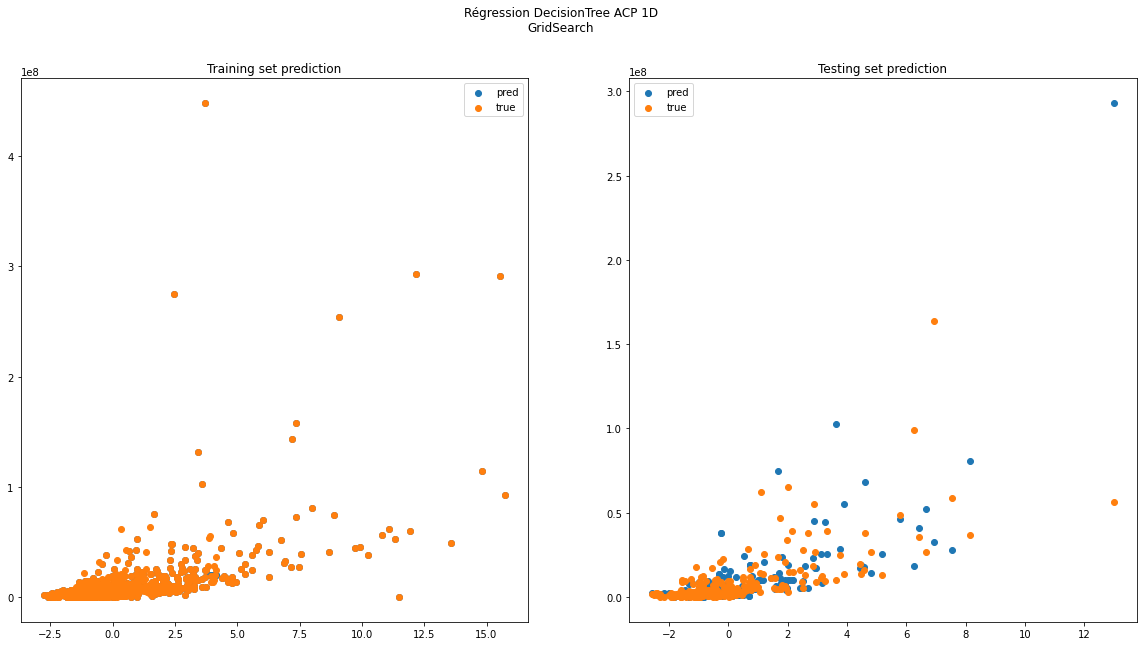

In [59]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
plt.suptitle("Régression DecisionTree ACP 1D\nGridSearch")
ax[0].set_title("Training set prediction")
ax[0].scatter(X_train,y_pred_train,label='pred')
ax[0].scatter(X_train, y_train,label='true')
ax[0].legend()
ax[1].set_title("Testing set prediction")
ax[1].scatter(X_test,y_pred,label='pred')
ax[1].scatter(X_test, y_test,label='true')
ax[1].legend()

##### Random Forest

In [60]:
from sklearn.ensemble import RandomForestRegressor as RFR

In [61]:
RFR().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [62]:
dist = dict(
        ccp_alpha = uniform(loc=0,scale=5),
        criterion = ['mse', 'mae'],
        bootstrap =  [True, False],
        max_features = ['auto', 'sqrt', 'log2']
)
clf = rscv(RFR(), dist, random_state=0)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(x1d, tar[col], test_size=0.2)

In [64]:
t0 = time()
srch = clf.fit(X_train,y_train)

t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  41.927998304367065


In [65]:
print(srch.best_params_)

{'bootstrap': True, 'ccp_alpha': 4.818313802505147, 'criterion': 'mse', 'max_features': 'sqrt'}


In [66]:
t0 = time()
rfr_rs = RFR(ccp_alpha=srch.best_params_['ccp_alpha'], 
            criterion=srch.best_params_['criterion'],
            bootstrap=srch.best_params_['bootstrap'],
            max_features=srch.best_params_['max_features'],
           )

y_pred_train = rfr_rs.fit(X_train,y_train).predict(X_train)
y_pred = rfr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.4699985980987549


In [67]:
rfr_r2 = r2_score(y_test,y_pred)
rfr_mse = mean_squared_error(y_test,y_pred)
rfr_mae = mean_absolute_error(y_test,y_pred)
rfr_test = rfr_rs.score(X_test, y_test)
rfr_train = rfr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',rfr_train)
print("\tscore de la prédiction: ",  rfr_test), 
print("\tMAE = ", rfr_mae)
print("\tMSE = ", rfr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.8262920861650098
	score de la prédiction:  -0.15317537715511453
	MAE =  5736129.615695253
	MSE =  178993173908198.6

----------------------------------------------



In [68]:
row =  {'model':'RandomForest', 'tuning':'randomsearch', 'data_dimension':x1d.shape[1], 'mse':rfr_mse, 'mae':rfr_mae, 'r2':rfr_r2, 'training_score':rfr_train, 'testing_score':rfr_test}

In [69]:
comparative_ele = comparative_ele.append(row, ignore_index=True)

In [70]:
comparative_ele

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,gridsearch,1,3.701689e+14,7.590240e+06,0.428900,0.295813,0.428900
1,SVR,gridsearch,1,3.890243e+14,6.137285e+06,-0.005347,0.154617,-0.005347
2,SVR,randomsearch,1,3.183405e+14,6.188418e+06,0.188525,0.090135,0.188525
3,KernelRidge,randomsearch,1,7.791460e+13,4.849323e+06,0.273066,0.370657,0.273066
4,DecisionTree,randomsearch,1,3.694335e+14,6.495991e+06,-0.730652,0.983922,-0.730652
5,RandomForest,randomsearch,1,1.789932e+14,5.736130e+06,-0.153175,0.826292,-0.153175


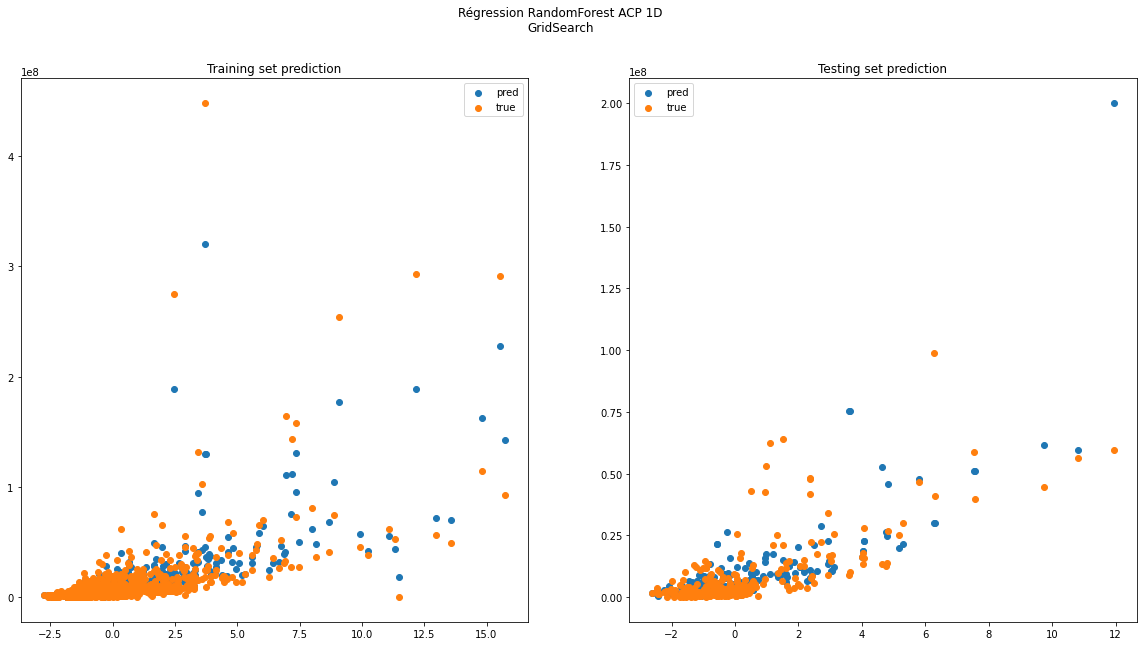

In [71]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
plt.suptitle("Régression RandomForest ACP 1D\nGridSearch")
ax[0].set_title("Training set prediction")
ax[0].scatter(X_train,y_pred_train,label='pred')
ax[0].scatter(X_train, y_train,label='true')
ax[0].legend()
ax[1].set_title("Testing set prediction")
ax[1].scatter(X_test,y_pred,label='pred')
ax[1].scatter(X_test, y_test,label='true')
ax[1].legend()

##### XGBoost Regressor

In [72]:
import xgboost as xgb
from xgboost import XGBRegressor as XGBR

In [73]:
from sklearn.model_selection import cross_val_score

In [74]:
X_train, X_test, y_train, y_test = train_test_split(x1d, tar[col], test_size=0.2)

In [75]:
params = {
    'min_child_weight':[4,5], 
    'gamma':uniform(loc=0,scale=1),  
    'subsample':uniform(loc=0,scale=1),
    'colsample_bytree':uniform(loc=0,scale=1), 
    'max_depth': [2,3,5,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eta': uniform(loc=0,scale=1),
}

reg = XGBR(nthreads=-1)
clf = rscv(reg, params, random_state=0)

In [76]:
start = time()
srch = clf.fit(X_train, y_train)
print("temps de process : ", time()-start)

[17:29:13] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:29:13] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:29:13] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:29:13]

In [77]:
t0 = time()
xgbr_rs = XGBR(
    min_child_weight=srch.best_params_['min_child_weight'], 
    gamma=srch.best_params_['gamma'],  
    subsample=srch.best_params_['subsample'],
    colsample_bytree=srch.best_params_['colsample_bytree'], 
    max_depth=srch.best_params_['max_depth'],
    objective=srch.best_params_['objective'],
    booster=srch.best_params_['booster'],
    eta=srch.best_params_['eta']
           )

y_pred_train = xgbr_rs.fit(X_train,y_train).predict(X_train)
y_pred = xgbr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

[17:29:15] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:29:15] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


temps de calcul :  0.025999069213867188


In [78]:
xgbr_r2 = r2_score(y_test,y_pred)
xgbr_mse = mean_squared_error(y_test,y_pred)
xgbr_mae = mean_absolute_error(y_test,y_pred)
xgbr_test = xgbr_rs.score(X_test, y_test)
xgbr_train = xgbr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',xgbr_train)
print("\tscore de la prédiction: ",  xgbr_test), 
print("\tMAE = ", xgbr_mae)
print("\tMSE = ", xgbr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.3781163871450076
	score de la prédiction:  0.2626899906251021
	MAE =  7567080.360806895
	MSE =  735351826620526.4

----------------------------------------------



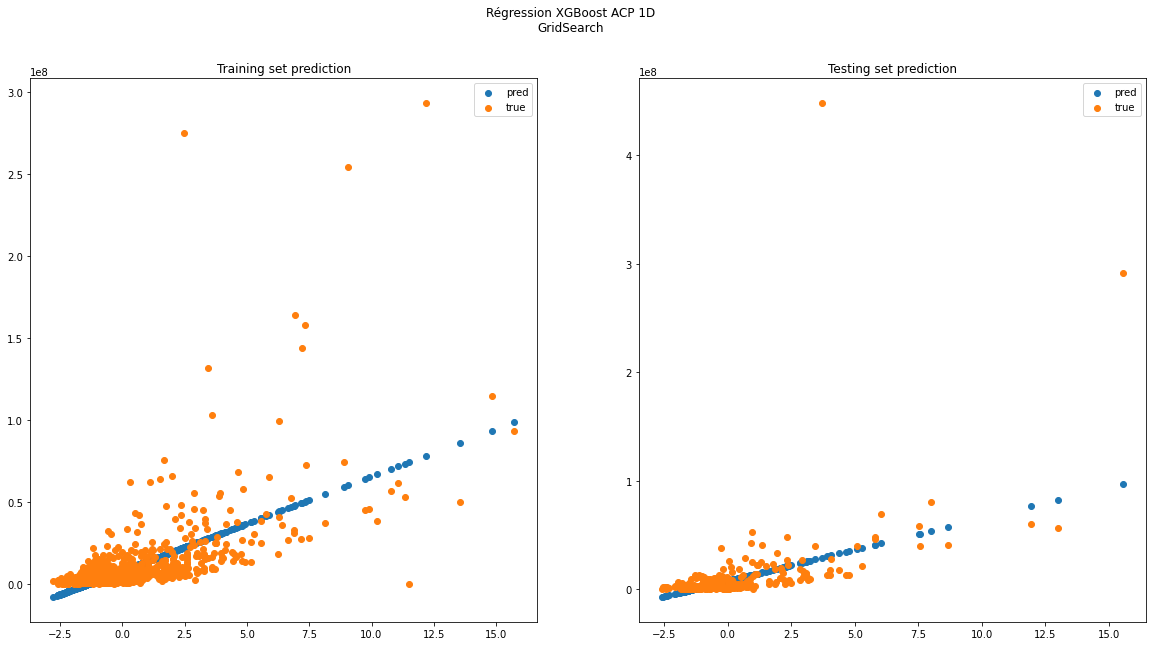

In [79]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
plt.suptitle("Régression XGBoost ACP 1D\nGridSearch")
ax[0].set_title("Training set prediction")
ax[0].scatter(X_train,y_pred_train,label='pred')
ax[0].scatter(X_train, y_train,label='true')
ax[0].legend()
ax[1].set_title("Testing set prediction")
ax[1].scatter(X_test,y_pred,label='pred')
ax[1].scatter(X_test, y_test,label='true')
ax[1].legend()

In [80]:
row =  {'model':'XGBR', 'tuning':'randomsearch', 'data_dimension':x1d.shape[1], 'mse':xgbr_mse, 'mae':xgbr_mae, 'r2':xgbr_r2, 'training_score':xgbr_train, 'testing_score':xgbr_test}

In [81]:
comparative_ele = comparative_ele.append(row, ignore_index=True)

In [82]:
comparative_ele

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,gridsearch,1,3.701689e+14,7.590240e+06,0.428900,0.295813,0.428900
1,SVR,gridsearch,1,3.890243e+14,6.137285e+06,-0.005347,0.154617,-0.005347
2,SVR,randomsearch,1,3.183405e+14,6.188418e+06,0.188525,0.090135,0.188525
3,KernelRidge,randomsearch,1,7.791460e+13,4.849323e+06,0.273066,0.370657,0.273066
4,DecisionTree,randomsearch,1,3.694335e+14,6.495991e+06,-0.730652,0.983922,-0.730652
5,RandomForest,randomsearch,1,1.789932e+14,5.736130e+06,-0.153175,0.826292,-0.153175
6,XGBR,randomsearch,1,7.353518e+14,7.567080e+06,0.262690,0.378116,0.262690


### Modélisation sur dataset complet

#### Ridge

In [83]:
Ridge().get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'random_state', 'solver', 'tol'])

In [84]:
solver = ['auto','svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
dist = dict(alpha=uniform(loc=0,scale=1E5), solver=solver)

In [85]:
clf = rscv(Ridge(), dist, random_state=0)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [87]:
t0 = time()
srch = clf.fit(X_train,y_train)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.5219986438751221


In [88]:
x.shape

(1595, 102)

In [89]:
y_train.shape

(1276,)

In [90]:
t0 = time()
ridge_rs = Ridge(alpha=srch.best_params_['alpha'],
                solver=srch.best_params_['solver'])

y_pred_train = ridge_rs.fit(X_train,y_train).predict(X_train)
y_pred = ridge_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)


temps de calcul :  0.018000364303588867


In [91]:
ridge_r2 = r2_score(y_test,y_pred)
ridge_mse = mean_squared_error(y_test,y_pred)
ridge_mae = mean_absolute_error(y_test,y_pred)
ridge_test = ridge_rs.score(X_test, y_test)
ridge_train = ridge_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',ridge_train)
print("\tscore de la prédiction: ",  ridge_test), 
print("\tMAE = ", ridge_mae)
print("\tMSE = ", ridge_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.39810324614108783
	score de la prédiction:  0.3286659111374579
	MAE =  5914138.103342455
	MSE =  300353900369776.8

----------------------------------------------



In [92]:
row = {'model':'Ridge', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':ridge_mse, 'mae':ridge_mae, 'r2':ridge_r2, 'training_score':ridge_train, 'testing_score':ridge_test}

In [93]:
comparative_ele = comparative_ele.append(row, ignore_index=True)

In [94]:
comparative_ele

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,gridsearch,1,3.701689e+14,7.590240e+06,0.428900,0.295813,0.428900
1,SVR,gridsearch,1,3.890243e+14,6.137285e+06,-0.005347,0.154617,-0.005347
2,SVR,randomsearch,1,3.183405e+14,6.188418e+06,0.188525,0.090135,0.188525
3,KernelRidge,randomsearch,1,7.791460e+13,4.849323e+06,0.273066,0.370657,0.273066
4,DecisionTree,randomsearch,1,3.694335e+14,6.495991e+06,-0.730652,0.983922,-0.730652
5,RandomForest,randomsearch,1,1.789932e+14,5.736130e+06,-0.153175,0.826292,-0.153175
6,XGBR,randomsearch,1,7.353518e+14,7.567080e+06,0.262690,0.378116,0.262690
7,Ridge,randomsearch,102,3.003539e+14,5.914138e+06,0.328666,0.398103,0.328666


#### Decision Tree

In [95]:
DTR().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [96]:
dist = dict(
        ccp_alpha = uniform(loc=0,scale=5),
        criterion = ['mse', 'friedman_mse', 'mae', 'poisson'],
        splitter = ['best', 'random'],
        max_features = ['auto', 'sqrt', 'log2']
)
clf = rscv(DTR(), dist, random_state=0)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [98]:
t0 = time()
srch = clf.fit(X_train,y_train)

t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  1.723029613494873


In [99]:
print(srch.best_params_)

{'ccp_alpha': 4.627983191463305, 'criterion': 'friedman_mse', 'max_features': 'auto', 'splitter': 'random'}


In [100]:
t0 = time()
dtr_rs = DTR(ccp_alpha=srch.best_params_['ccp_alpha'], 
            criterion=srch.best_params_['criterion'],
            splitter=srch.best_params_['splitter'],
            max_features=srch.best_params_['max_features'],
           )

y_pred_train = dtr_rs.fit(X_train,y_train).predict(X_train)
y_pred = dtr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.03600263595581055


In [101]:
dtr_r2 = r2_score(y_test,y_pred)
dtr_mse = mean_squared_error(y_test,y_pred)
dtr_mae = mean_absolute_error(y_test,y_pred)
dtr_test = dtr_rs.score(X_test, y_test)
dtr_train = dtr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',dtr_train)
print("\tscore de la prédiction: ",  dtr_test), 
print("\tMAE = ", dtr_mae)
print("\tMSE = ", dtr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  1.0
	score de la prédiction:  0.2800257042250822
	MAE =  3990947.7310784953
	MSE =  303397522058150.8

----------------------------------------------



In [102]:
row = {'model':'DecisionTree', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':dtr_mse, 'mae':dtr_mae, 'r2':dtr_r2, 'training_score':dtr_train, 'testing_score':dtr_test}

In [103]:
comparative_ele = comparative_ele.append(row, ignore_index=True)

In [104]:
comparative_ele

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,gridsearch,1,3.701689e+14,7.590240e+06,0.428900,0.295813,0.428900
1,SVR,gridsearch,1,3.890243e+14,6.137285e+06,-0.005347,0.154617,-0.005347
2,SVR,randomsearch,1,3.183405e+14,6.188418e+06,0.188525,0.090135,0.188525
3,KernelRidge,randomsearch,1,7.791460e+13,4.849323e+06,0.273066,0.370657,0.273066
4,DecisionTree,randomsearch,1,3.694335e+14,6.495991e+06,-0.730652,0.983922,-0.730652
5,RandomForest,randomsearch,1,1.789932e+14,5.736130e+06,-0.153175,0.826292,-0.153175
6,XGBR,randomsearch,1,7.353518e+14,7.567080e+06,0.262690,0.378116,0.262690
7,Ridge,randomsearch,102,3.003539e+14,5.914138e+06,0.328666,0.398103,0.328666
8,DecisionTree,randomsearch,102,3.033975e+14,3.990948e+06,0.280026,1.000000,0.280026


#### Random Forest

In [105]:
RFR().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [106]:
dist = dict(
        ccp_alpha = uniform(loc=0,scale=5),
        criterion = ['mse', 'mae'],
        bootstrap =  [True, False],
        max_features = ['auto', 'sqrt', 'log2']
)
clf = rscv(RFR(), dist, random_state=0)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [108]:
# warning temps long

t0 = time()
srch = clf.fit(X_train,y_train)

t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  351.88723492622375


In [109]:
print(srch.best_params_)

{'bootstrap': True, 'ccp_alpha': 4.818313802505147, 'criterion': 'mse', 'max_features': 'sqrt'}


In [110]:
t0 = time()
rfr_rs = RFR(ccp_alpha=srch.best_params_['ccp_alpha'], 
            criterion=srch.best_params_['criterion'],
            bootstrap=srch.best_params_['bootstrap'],
            max_features=srch.best_params_['max_features'],
           )

y_pred_train = rfr_rs.fit(X_train,y_train).predict(X_train)
y_pred = rfr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.6350293159484863


In [111]:
rfr_r2 = r2_score(y_test,y_pred)
rfr_mse = mean_squared_error(y_test,y_pred)
rfr_mae = mean_absolute_error(y_test,y_pred)
rfr_test = rfr_rs.score(X_test, y_test)
rfr_train = rfr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',rfr_train)
print("\tscore de la prédiction: ",  rfr_test), 
print("\tMAE = ", rfr_mae)
print("\tMSE = ", rfr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.9315039478157947
	score de la prédiction:  0.8366112912832796
	MAE =  3503702.814635419
	MSE =  109758259098310.44

----------------------------------------------



In [112]:
row = {'model':'RandomForest', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':rfr_mse, 'mae':rfr_mae, 'r2':rfr_r2, 'training_score':rfr_train, 'testing_score':rfr_test}

In [113]:
comparative_ele = comparative_ele.append(row, ignore_index=True)

In [114]:
comparative_ele

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,gridsearch,1,3.701689e+14,7.590240e+06,0.428900,0.295813,0.428900
1,SVR,gridsearch,1,3.890243e+14,6.137285e+06,-0.005347,0.154617,-0.005347
2,SVR,randomsearch,1,3.183405e+14,6.188418e+06,0.188525,0.090135,0.188525
3,KernelRidge,randomsearch,1,7.791460e+13,4.849323e+06,0.273066,0.370657,0.273066
4,DecisionTree,randomsearch,1,3.694335e+14,6.495991e+06,-0.730652,0.983922,-0.730652
5,RandomForest,randomsearch,1,1.789932e+14,5.736130e+06,-0.153175,0.826292,-0.153175
6,XGBR,randomsearch,1,7.353518e+14,7.567080e+06,0.262690,0.378116,0.262690
7,Ridge,randomsearch,102,3.003539e+14,5.914138e+06,0.328666,0.398103,0.328666
8,DecisionTree,randomsearch,102,3.033975e+14,3.990948e+06,0.280026,1.000000,0.280026
9,RandomForest,randomsearch,102,1.097583e+14,3.503703e+06,0.836611,0.931504,0.836611


#### SVR

In [115]:
SVR().get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [116]:
dist = dict(C=uniform(loc=0, scale=10), degree=[2,3,4,5,6,7], 
            epsilon=uniform(loc=0, scale=1), 
            kernel = ['poly','rbf', 'sigmoid'],
           )
clf = rscv(SVR(), dist, random_state=0)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [118]:
t0 = time()
srch = clf.fit(X_train,y_train)
print(srch.best_params_)
t1=time()
print("temps de calcul : ", t1-t0)

{'C': 7.742336894342166, 'degree': 6, 'epsilon': 0.5684339488686485, 'kernel': 'poly'}
temps de calcul :  4.437027454376221


In [119]:
t0 = time()
svr_rs = SVR(C=srch.best_params_['C'], 
            kernel=srch.best_params_['kernel'],
            degree=srch.best_params_['degree'],
            epsilon=srch.best_params_['epsilon'],
           )

y_pred_train = svr_rs.fit(X_train,y_train).predict(X_train)
y_pred = svr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)


temps de calcul :  0.28802967071533203


In [120]:
svr_r2 = r2_score(y_test,y_pred)
svr_mse = mean_squared_error(y_test,y_pred)
svr_mae = mean_absolute_error(y_test,y_pred)
svr_test = svr_rs.score(X_test, y_test)
svr_train = svr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',svr_train)
print("\tscore de la prédiction: ",  svr_test), 
print("\tMAE = ", svr_mae)
print("\tMSE = ", svr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  -0.051760011877516554
	score de la prédiction:  -0.09975018049950735
	MAE =  5875278.420782264
	MSE =  209271444290455.56

----------------------------------------------



In [121]:
row = {'model':'SVR', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':svr_mse, 'mae':svr_mae, 'r2':svr_r2, 'training_score':svr_train, 'testing_score':svr_test}

In [122]:
comparative_ele = comparative_ele.append(row, ignore_index=True)

In [123]:
comparative_ele

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,gridsearch,1,3.701689e+14,7.590240e+06,0.428900,0.295813,0.428900
1,SVR,gridsearch,1,3.890243e+14,6.137285e+06,-0.005347,0.154617,-0.005347
2,SVR,randomsearch,1,3.183405e+14,6.188418e+06,0.188525,0.090135,0.188525
3,KernelRidge,randomsearch,1,7.791460e+13,4.849323e+06,0.273066,0.370657,0.273066
4,DecisionTree,randomsearch,1,3.694335e+14,6.495991e+06,-0.730652,0.983922,-0.730652
5,RandomForest,randomsearch,1,1.789932e+14,5.736130e+06,-0.153175,0.826292,-0.153175
6,XGBR,randomsearch,1,7.353518e+14,7.567080e+06,0.262690,0.378116,0.262690
7,Ridge,randomsearch,102,3.003539e+14,5.914138e+06,0.328666,0.398103,0.328666
8,DecisionTree,randomsearch,102,3.033975e+14,3.990948e+06,0.280026,1.000000,0.280026
9,RandomForest,randomsearch,102,1.097583e+14,3.503703e+06,0.836611,0.931504,0.836611


#### Kernel Ridge

In [124]:
from sklearn.kernel_ridge import KernelRidge

In [125]:
KernelRidge().get_params().keys()

dict_keys(['alpha', 'coef0', 'degree', 'gamma', 'kernel', 'kernel_params'])

In [126]:
dist = dict(alpha= uniform(loc=0, scale=10),
    kernel= ['additive_chi2', 'chi2', 'linear', 'poly', 'rbf', 'laplacian', 'sigmoid', 'cosine'],
    gamma= uniform(loc=-10,scale=10),
    degree= [1,2,3,4,5,6,7],
    coef0=uniform(loc=-10,scale=10)  
           )
clf = rscv(KernelRidge(), dist, random_state=0)

In [127]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [128]:
t0 = time()
srch = clf.fit(X_train,y_train)

t1=time()
print("temps de calcul : ", t1-t0)

D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\kernel_ridge.py", line 172, in fit
    K = self._get_kernel(X)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\kernel_ridge.py", line 133, in _get_kernel
    return pairwise_kernels(X, Y, metric=self.kernel,
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\metrics\pairwise.py", line 1954, in pairwise_kerne

temps de calcul :  2.4059979915618896


D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\metrics\pairwise.py:1141: RuntimeWarning: overflow encountered in exp
  np.exp(K, K)  # exponentiate K in-place
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\kernel_ridge.py", line 181, in fit
    self.dual_coef_ = _solve_cholesky_kernel(K, y, alpha,
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\linear_model\_ridge.py", line 187, in _solve_cholesky_kernel
    dual_coef = linalg.solve(K, y, sym_pos=True,
  File "D:\Programmes\Anaconda3\envs\oc-00\l

In [129]:
print(srch.best_params_)

{'alpha': 5.4881350392732475, 'coef0': -2.848106336275805, 'degree': 4, 'gamma': -1.420543823772432, 'kernel': 'cosine'}


In [130]:
t0 = time()
kr_rs = KernelRidge(alpha=srch.best_params_['alpha'], 
            kernel=srch.best_params_['kernel'],
            degree=srch.best_params_['degree'],
            gamma=srch.best_params_['gamma'],
            coef0=srch.best_params_['coef0']
           )

y_pred_train = kr_rs.fit(X_train,y_train).predict(X_train)
y_pred = kr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.0840003490447998


In [131]:
kr_r2 = r2_score(y_test,y_pred)
kr_mse = mean_squared_error(y_test,y_pred)
kr_mae = mean_absolute_error(y_test,y_pred)
kr_test = kr_rs.score(X_test, y_test)
kr_train = kr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',kr_train)
print("\tscore de la prédiction: ",  kr_test), 
print("\tMAE = ", kr_mae)
print("\tMSE = ", kr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.2720548661416703
	score de la prédiction:  0.4095646816684462
	MAE =  9571408.923838492
	MSE =  253914318613329.66

----------------------------------------------



In [132]:
row = {'model':'KernelRidge', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':kr_mse, 'mae':kr_mae, 'r2':kr_r2, 'training_score':kr_train, 'testing_score':kr_test}

In [133]:
comparative_ele = comparative_ele.append(row, ignore_index=True)

In [134]:
comparative_ele

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,gridsearch,1,3.701689e+14,7.590240e+06,0.428900,0.295813,0.428900
1,SVR,gridsearch,1,3.890243e+14,6.137285e+06,-0.005347,0.154617,-0.005347
2,SVR,randomsearch,1,3.183405e+14,6.188418e+06,0.188525,0.090135,0.188525
3,KernelRidge,randomsearch,1,7.791460e+13,4.849323e+06,0.273066,0.370657,0.273066
4,DecisionTree,randomsearch,1,3.694335e+14,6.495991e+06,-0.730652,0.983922,-0.730652
5,RandomForest,randomsearch,1,1.789932e+14,5.736130e+06,-0.153175,0.826292,-0.153175
6,XGBR,randomsearch,1,7.353518e+14,7.567080e+06,0.262690,0.378116,0.262690
7,Ridge,randomsearch,102,3.003539e+14,5.914138e+06,0.328666,0.398103,0.328666
8,DecisionTree,randomsearch,102,3.033975e+14,3.990948e+06,0.280026,1.000000,0.280026
9,RandomForest,randomsearch,102,1.097583e+14,3.503703e+06,0.836611,0.931504,0.836611


#### XGBoost Regressor

In [135]:
dmatrix = xgb.DMatrix(data=x1d,label=tar[col])

In [136]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [137]:
params = {
    'min_child_weight':[4,5], 
    'gamma':uniform(loc=0,scale=1),  
    'subsample':uniform(loc=0,scale=1),
    'colsample_bytree':uniform(loc=0,scale=1), 
    'max_depth': [2,3,5,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eta': uniform(loc=0,scale=1),
}

reg = XGBR(nthreads=-1)
clf = rscv(reg, params, random_state=0)

In [138]:
start = time()
srch = clf.fit(X_train, y_train)
print("temps de process : ", time()-start)

[17:35:18] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:35:18] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:18] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:35:18] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:19] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:35:19] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:19] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:19] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:35:19] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:19] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:19] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:35:19] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:19] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:19] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:35:19] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:19] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:20] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:35:20] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:20] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:20] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:35:20] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:20] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:20] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:35:20] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:20] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:20] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "nthreads", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:35:21] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:21] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:21] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:35:21] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:21] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "nthreads", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:21] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "nthreads", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed d

D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:35:21] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:21] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:35:21] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:22] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:35:22] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "nthreads", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

In [139]:
t0 = time()
xgbr_rs = XGBR(
    min_child_weight=srch.best_params_['min_child_weight'], 
    gamma=srch.best_params_['gamma'],  
    subsample=srch.best_params_['subsample'],
    colsample_bytree=srch.best_params_['colsample_bytree'], 
    max_depth=srch.best_params_['max_depth'],
    objective=srch.best_params_['objective'],
    booster=srch.best_params_['booster'],
    eta=srch.best_params_['eta']
           )

y_pred_train = xgbr_rs.fit(X_train,y_train).predict(X_train)
y_pred = xgbr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.194000244140625


D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [140]:
xgbr_r2 = r2_score(y_test,y_pred)
xgbr_mse = mean_squared_error(y_test,y_pred)
xgbr_mae = mean_absolute_error(y_test,y_pred)
xgbr_test = xgbr_rs.score(X_test, y_test)
xgbr_train = xgbr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',xgbr_train)
print("\tscore de la prédiction: ",  xgbr_test), 
print("\tMAE = ", xgbr_mae)
print("\tMSE = ", xgbr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.9843185289657133
	score de la prédiction:  0.3677499245388185
	MAE =  3771175.502167053
	MSE =  96225231194002.16

----------------------------------------------



D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [141]:
row =  {'model':'XGBR', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':xgbr_mse, 'mae':xgbr_mae, 'r2':xgbr_r2, 'training_score':xgbr_train, 'testing_score':xgbr_test}

In [142]:
comparative_ele = comparative_ele.append(row, ignore_index=True)

In [143]:
comparative_ele

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,gridsearch,1,3.701689e+14,7.590240e+06,0.428900,0.295813,0.428900
1,SVR,gridsearch,1,3.890243e+14,6.137285e+06,-0.005347,0.154617,-0.005347
2,SVR,randomsearch,1,3.183405e+14,6.188418e+06,0.188525,0.090135,0.188525
3,KernelRidge,randomsearch,1,7.791460e+13,4.849323e+06,0.273066,0.370657,0.273066
4,DecisionTree,randomsearch,1,3.694335e+14,6.495991e+06,-0.730652,0.983922,-0.730652
5,RandomForest,randomsearch,1,1.789932e+14,5.736130e+06,-0.153175,0.826292,-0.153175
6,XGBR,randomsearch,1,7.353518e+14,7.567080e+06,0.262690,0.378116,0.262690
7,Ridge,randomsearch,102,3.003539e+14,5.914138e+06,0.328666,0.398103,0.328666
8,DecisionTree,randomsearch,102,3.033975e+14,3.990948e+06,0.280026,1.000000,0.280026
9,RandomForest,randomsearch,102,1.097583e+14,3.503703e+06,0.836611,0.931504,0.836611


### Feature Selection

In [144]:
from sklearn.feature_selection import SelectKBest as SKB, f_regression

In [145]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [146]:
myk = np.array([i for i in range(X_train.shape[1])])[::-1]

In [147]:
min_errs_ele = []

In [148]:
errs_dtr = []

#### Decision Tree

In [149]:
for k in myk:
    print(k+1)
    sel = SKB(f_regression, k=k+1)
    xfeat = sel.fit_transform(x,tar[col])
    Xf_train, Xf_test, yf_train, yf_test = train_test_split(xfeat, tar[col], test_size=0.2, random_state=13)
    
    if k+1 == x.shape[1]:
        ## Hyperparameters tunning
        dist = dict(
            ccp_alpha = uniform(loc=0,scale=5),
            criterion = ['mse', 'friedman_mse', 'mae', 'poisson'],
            splitter = ['best', 'random'],
            max_features = ['auto', 'sqrt', 'log2']
        )
        clf = rscv(DTR(), dist, random_state=0)


        t0 = time()
        srch = clf.fit(Xf_train,yf_train)
        t1=time()
        #print("temps tuning {} : ".format(k+1), t1-t0)
    
    
    ## Fitting model
    t0 = time()
    dtrf_rs = DTR(
        ccp_alpha=srch.best_params_['ccp_alpha'], 
        criterion=srch.best_params_['criterion'],
        splitter=srch.best_params_['splitter'],
        max_features=srch.best_params_['max_features'],
               )

    yf_pred_train = dtrf_rs.fit(Xf_train,yf_train).predict(Xf_train)
    yf_pred = dtrf_rs.fit(Xf_train,yf_train).predict(Xf_test)
    t1=time()
    #print("temps fitting {} : ".format(k+1), t1-t0)
    
    dtrf_mae = mean_absolute_error(yf_test,yf_pred)
    
    errs_dtr.append(dtrf_mae)    

102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [150]:
print("la plus petite erreur est avec : ",myk[np.argmin(errs_dtr)]+1, "features.", "Elle est de : ",np.min(errs_dtr))

la plus petite erreur est avec :  98 features. Elle est de :  3256598.2861807523


In [151]:
min_errs_ele.append(np.min(errs_dtr))

#### Kernel Ridge

In [152]:
errs_kr = []
for k in myk:
    print(k+1)
    sel = SKB(f_regression, k=k+1)
    xfeat = sel.fit_transform(x,tar[col])
    Xf_train, Xf_test, yf_train, yf_test = train_test_split(xfeat, tar[col], test_size=0.2, random_state=13)
    
    if k+1 == x.shape[1]:
        ## Hyperparameters tunning
        dist = dict(alpha= uniform(loc=0, scale=10),
        kernel= ['additive_chi2', 'chi2', 'linear', 'poly', 'rbf', 'laplacian', 'sigmoid', 'cosine'],
        gamma= uniform(loc=-10,scale=10),
        degree= [1,2,3,4,5,6,7],
        coef0=uniform(loc=-10,scale=10)) 

        clf = rscv(KernelRidge(), dist, random_state=0)


        t0 = time()
        srch = clf.fit(Xf_train,yf_train)
        t1=time()
        #print("temps tuning {} : ".format(k+1), t1-t0)
    
    
    ## Fitting model
    t0 = time()
    kr_rs = KernelRidge(alpha=srch.best_params_['alpha'], 
            kernel=srch.best_params_['kernel'],
            degree=srch.best_params_['degree'],
            gamma=srch.best_params_['gamma'],
            coef0=srch.best_params_['coef0']
           )

    yf_pred_train = kr_rs.fit(Xf_train,yf_train).predict(Xf_train)
    yf_pred = kr_rs.fit(Xf_train,yf_train).predict(Xf_test)
    t1=time()
    #print("temps fitting {} : ".format(k+1), t1-t0)
    
    err = mean_absolute_error(yf_test,yf_pred)
    
    errs_kr.append(err)    

102


D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\kernel_ridge.py", line 172, in fit
    K = self._get_kernel(X)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\kernel_ridge.py", line 133, in _get_kernel
    return pairwise_kernels(X, Y, metric=self.kernel,
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\metrics\pairwise.py", line 1954, in pairwise_kerne

101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [153]:
print("la plus petite erreur est avec : ",myk[np.argmin(errs_kr)]+1, "features.", "Elle est de : ",np.min(errs_kr))

la plus petite erreur est avec :  5 features. Elle est de :  8084740.633401372


In [154]:
min_errs_ele.append(np.min(errs_kr))

#### SVR

In [155]:
errs_svr = []
for k in myk:
    print(k+1)
    sel = SKB(f_regression, k=k+1)
    xfeat = sel.fit_transform(x,tar[col])
    Xf_train, Xf_test, yf_train, yf_test = train_test_split(xfeat, tar[col], test_size=0.2, random_state=13)
    
    if k+1 == x.shape[1]:
        ## Hyperparameters tunning
        dist = dict(C=uniform(loc=0, scale=10), degree=[2,3,4,5,6,7], 
                epsilon=uniform(loc=0, scale=1), 
                kernel = ['poly','rbf', 'sigmoid'],
               )

        clf = rscv(SVR(), dist, random_state=0)


        t0 = time()
        srch = clf.fit(Xf_train,yf_train)
        t1=time()
        #print("temps tuning {} : ".format(k+1), t1-t0)

    
    ## Fitting model
    t0 = time()
    svr_rs = SVR(C=srch.best_params_['C'], 
            kernel=srch.best_params_['kernel'],
            degree=srch.best_params_['degree'],
            epsilon=srch.best_params_['epsilon'],
           )

    yf_pred_train = svr_rs.fit(Xf_train,yf_train).predict(Xf_train)
    yf_pred = svr_rs.fit(Xf_train,yf_train).predict(Xf_test)
    t1=time()
    #print("temps fitting {} : ".format(k+1), t1-t0)
    
    err = mean_absolute_error(yf_test,yf_pred)
    
    errs_svr.append(err)    

102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [156]:
print("la plus petite erreur est avec : ",myk[np.argmin(errs_svr)]+1, "features.", "Elle est de : ",np.min(errs_svr))

la plus petite erreur est avec :  15 features. Elle est de :  5973559.923715261


In [157]:
min_errs_ele.append(np.min(errs_svr))

#### Random Forest

In [158]:
errs_rfr = []
for k in myk:
    print(k+1)
    sel = SKB(f_regression, k=k+1)
    xfeat = sel.fit_transform(x,tar[col])
    Xf_train, Xf_test, yf_train, yf_test = train_test_split(xfeat, tar[col], test_size=0.2, random_state=13)
    
    if k+1 == x.shape[1]:
        ## Hyperparameters tunning
        dist = dict(
            ccp_alpha = uniform(loc=0,scale=5),
            criterion = ['mse', 'mae'],
            bootstrap =  [True, False],
            max_features = ['auto', 'sqrt', 'log2']
    )

        clf = rscv(RFR(), dist, random_state=0)


        t0 = time()
        srch = clf.fit(Xf_train,yf_train)
        t1=time()
        #print("temps tuning {} : ".format(k+1), t1-t0)

    
    ## Fitting model
    t0 = time()
    rfr_rs = RFR(ccp_alpha=srch.best_params_['ccp_alpha'], 
            criterion=srch.best_params_['criterion'],
            bootstrap=srch.best_params_['bootstrap'],
            max_features=srch.best_params_['max_features'],
           )

    yf_pred_train = rfr_rs.fit(Xf_train,yf_train).predict(Xf_train)
    yf_pred = rfr_rs.fit(Xf_train,yf_train).predict(Xf_test)
    t1=time()
    #print("temps fitting {} : ".format(k+1), t1-t0)
    
    err = mean_absolute_error(yf_test,yf_pred)
    
    errs_rfr.append(err)    

102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [159]:
print("la plus petite erreur est avec : ",myk[np.argmin(errs_rfr)]+1, "features.", "Elle est de : ",np.min(errs_rfr))

la plus petite erreur est avec :  90 features. Elle est de :  2843392.3434804645


In [160]:
min_errs_ele.append(np.min(errs_rfr))

#### XGBR

In [161]:
errs_xgbr = []
for k in myk:
    print(k+1)
    sel = SKB(f_regression, k=k+1)
    xfeat = sel.fit_transform(x,tar[col])
    Xf_train, Xf_test, yf_train, yf_test = train_test_split(xfeat, tar[col], test_size=0.2, random_state=13)
    
    if k+1 == x.shape[1]:
        ## Hyperparameters tunning
        params = {
        'min_child_weight':[4,5], 
        'gamma':uniform(loc=0,scale=1),  
        'subsample':uniform(loc=0,scale=1),
        'colsample_bytree':uniform(loc=0,scale=1), 
        'max_depth': [2,3,5,7],
        'objective': ['reg:squarederror', 'reg:tweedie'],
        'booster': ['gbtree', 'gblinear'],
        'eta': uniform(loc=0,scale=1),
        }

        reg = XGBR(nthreads=-1)
        clf = rscv(reg, params, random_state=0)


        t0 = time()
        srch = clf.fit(Xf_train,yf_train)
        t1=time()
        #print("temps tuning {} : ".format(k+1), t1-t0)
    
    
    ## Fitting model
    t0 = time()
    xgbr_rs = XGBR(
                min_child_weight=srch.best_params_['min_child_weight'], 
                gamma=srch.best_params_['gamma'],  
                subsample=srch.best_params_['subsample'],
                colsample_bytree=srch.best_params_['colsample_bytree'], 
                max_depth=srch.best_params_['max_depth'],
                objective=srch.best_params_['objective'],
                booster=srch.best_params_['booster'],
                eta=srch.best_params_['eta']
           )

    yf_pred_train = xgbr_rs.fit(Xf_train,yf_train).predict(Xf_train)
    yf_pred = xgbr_rs.fit(Xf_train,yf_train).predict(Xf_test)
    t1=time()
    #print("temps fitting {} : ".format(k+1), t1-t0)
    
    err = mean_absolute_error(yf_test,yf_pred)
    
    errs_xgbr.append(err)    

102
[17:43:25] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:25] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:26] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43

In [162]:
print("la plus petite erreur est avec : ",myk[np.argmin(errs_xgbr)]+1, "features.", "Elle est de : ",np.min(errs_xgbr))

la plus petite erreur est avec :  86 features. Elle est de :  3275796.326437026


In [163]:
min_errs_ele.append(np.min(errs_xgbr))

### Résultats

In [164]:
np.argmin(min_errs_ele)

3

La plus petite erreur est pour le modèle Random Forest avec 101 features.

In [165]:
mydf2 = mydf.drop('ENERGYSTARScore',axis=1)

## Prédiction CO2

In [166]:
tar.columns

Index(['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)'], dtype='object')

### Modélisation sur dataset complet

#### Ridge

In [167]:
Ridge().get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'random_state', 'solver', 'tol'])

In [168]:
solver = ['auto','svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
dist = dict(alpha=uniform(loc=0,scale=1E5), solver=solver)

In [169]:
clf = rscv(Ridge(), dist, random_state=0)

In [170]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [171]:
t0 = time()
srch = clf.fit(X_train,y_train)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.5519990921020508


In [172]:
x.shape

(1595, 102)

In [173]:
y_train.shape

(1276,)

In [174]:
t0 = time()
ridge_rs = Ridge(alpha=srch.best_params_['alpha'],
                solver=srch.best_params_['solver'])

y_pred_train = ridge_rs.fit(X_train,y_train).predict(X_train)
y_pred = ridge_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)


temps de calcul :  0.013001441955566406


In [175]:
ridge_r2 = r2_score(y_test,y_pred)
ridge_mse = mean_squared_error(y_test,y_pred)
ridge_mae = mean_absolute_error(y_test,y_pred)
ridge_test = ridge_rs.score(X_test, y_test)
ridge_train = ridge_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',ridge_train)
print("\tscore de la prédiction: ",  ridge_test), 
print("\tMAE = ", ridge_mae)
print("\tMSE = ", ridge_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.3544183281794594
	score de la prédiction:  0.4921304584275483
	MAE =  5915717.458150669
	MSE =  227106435109191.53

----------------------------------------------



In [176]:
row = {'model':'Ridge', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':ridge_mse, 'mae':ridge_mae, 'r2':ridge_r2, 'training_score':ridge_train, 'testing_score':ridge_test}

In [177]:
comparative_co2_ess = comparative_co2_ess.append(row, ignore_index=True)

In [178]:
comparative_co2_ess

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,randomsearch,102,2.271064e+14,5.915717e+06,0.49213,0.354418,0.49213


#### Decision Tree

In [179]:
DTR().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [180]:
dist = dict(
        ccp_alpha = uniform(loc=0,scale=5),
        criterion = ['mse', 'friedman_mse', 'mae', 'poisson'],
        splitter = ['best', 'random'],
        max_features = ['auto', 'sqrt', 'log2']
)
clf = rscv(DTR(), dist, random_state=0)

In [181]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [182]:
t0 = time()
srch = clf.fit(X_train,y_train)

t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  1.9059982299804688


In [183]:
print(srch.best_params_)

{'ccp_alpha': 4.818313802505147, 'criterion': 'mae', 'max_features': 'sqrt', 'splitter': 'best'}


In [184]:
t0 = time()
dtr_rs = DTR(ccp_alpha=srch.best_params_['ccp_alpha'], 
            criterion=srch.best_params_['criterion'],
            splitter=srch.best_params_['splitter'],
            max_features=srch.best_params_['max_features'],
           )

y_pred_train = dtr_rs.fit(X_train,y_train).predict(X_train)
y_pred = dtr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.11797547340393066


In [185]:
dtr_r2 = r2_score(y_test,y_pred)
dtr_mse = mean_squared_error(y_test,y_pred)
dtr_mae = mean_absolute_error(y_test,y_pred)
dtr_test = dtr_rs.score(X_test, y_test)
dtr_train = dtr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',dtr_train)
print("\tscore de la prédiction: ",  dtr_test), 
print("\tMAE = ", dtr_mae)
print("\tMSE = ", dtr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.999347227132535
	score de la prédiction:  0.1288158328529656
	MAE =  4397226.725434703
	MSE =  179973515595092.2

----------------------------------------------



In [186]:
row = {'model':'DecisionTree', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':dtr_mse, 'mae':dtr_mae, 'r2':dtr_r2, 'training_score':dtr_train, 'testing_score':dtr_test}

In [187]:
comparative_co2_ess = comparative_co2_ess.append(row, ignore_index=True)

In [188]:
comparative_co2_ess

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,randomsearch,102,2.271064e+14,5.915717e+06,0.492130,0.354418,0.492130
1,DecisionTree,randomsearch,102,1.799735e+14,4.397227e+06,0.128816,0.999347,0.128816


#### Random Forest

In [189]:
RFR().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [190]:
dist = dict(
        ccp_alpha = uniform(loc=0,scale=5),
        criterion = ['mse', 'mae'],
        bootstrap =  [True, False],
        max_features = ['auto', 'sqrt', 'log2']
)
clf = rscv(RFR(), dist, random_state=0)

In [191]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [192]:
# warning temps long

t0 = time()
srch = clf.fit(X_train,y_train)

t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  364.52302980422974


In [193]:
print(srch.best_params_)

{'bootstrap': False, 'ccp_alpha': 3.2294705653332807, 'criterion': 'mse', 'max_features': 'log2'}


In [194]:
t0 = time()
rfr_rs = RFR(ccp_alpha=srch.best_params_['ccp_alpha'], 
            criterion=srch.best_params_['criterion'],
            bootstrap=srch.best_params_['bootstrap'],
            max_features=srch.best_params_['max_features'],
           )

y_pred_train = rfr_rs.fit(X_train,y_train).predict(X_train)
y_pred = rfr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.7209930419921875


In [195]:
rfr_r2 = r2_score(y_test,y_pred)
rfr_mse = mean_squared_error(y_test,y_pred)
rfr_mae = mean_absolute_error(y_test,y_pred)
rfr_test = rfr_rs.score(X_test, y_test)
rfr_train = rfr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',rfr_train)
print("\tscore de la prédiction: ",  rfr_test), 
print("\tMAE = ", rfr_mae)
print("\tMSE = ", rfr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  1.0
	score de la prédiction:  0.8272484375374966
	MAE =  2687609.62676213
	MSE =  33409379502839.06

----------------------------------------------



In [196]:
row = {'model':'RandomForest', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':rfr_mse, 'mae':rfr_mae, 'r2':rfr_r2, 'training_score':rfr_train, 'testing_score':rfr_test}

In [197]:
comparative_co2_ess = comparative_co2_ess.append(row, ignore_index=True)

In [198]:
comparative_co2_ess

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,randomsearch,102,2.271064e+14,5.915717e+06,0.492130,0.354418,0.492130
1,DecisionTree,randomsearch,102,1.799735e+14,4.397227e+06,0.128816,0.999347,0.128816
2,RandomForest,randomsearch,102,3.340938e+13,2.687610e+06,0.827248,1.000000,0.827248


#### SVR

In [199]:
SVR().get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [200]:
dist = dict(C=uniform(loc=0, scale=10), degree=[2,3,4,5,6,7], 
            epsilon=uniform(loc=0, scale=1), 
            kernel = ['poly','rbf', 'sigmoid'],
           )
clf = rscv(SVR(), dist, random_state=0)

In [201]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [202]:
t0 = time()
srch = clf.fit(X_train,y_train)
print(srch.best_params_)
t1=time()
print("temps de calcul : ", t1-t0)

{'C': 7.742336894342166, 'degree': 6, 'epsilon': 0.5684339488686485, 'kernel': 'poly'}
temps de calcul :  4.458028793334961


In [203]:
t0 = time()
svr_rs = SVR(C=srch.best_params_['C'], 
            kernel=srch.best_params_['kernel'],
            degree=srch.best_params_['degree'],
            epsilon=srch.best_params_['epsilon'],
           )

y_pred_train = svr_rs.fit(X_train,y_train).predict(X_train)
y_pred = svr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)


temps de calcul :  0.2829618453979492


In [204]:
svr_r2 = r2_score(y_test,y_pred)
svr_mse = mean_squared_error(y_test,y_pred)
svr_mae = mean_absolute_error(y_test,y_pred)
svr_test = svr_rs.score(X_test, y_test)
svr_train = svr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',svr_train)
print("\tscore de la prédiction: ",  svr_test), 
print("\tMAE = ", svr_mae)
print("\tMSE = ", svr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  -0.052270680373213585
	score de la prédiction:  -0.19201136200371005
	MAE =  6318385.997847819
	MSE =  178127943665205.56

----------------------------------------------



In [205]:
row = {'model':'SVR', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':svr_mse, 'mae':svr_mae, 'r2':svr_r2, 'training_score':svr_train, 'testing_score':svr_test}

In [206]:
comparative_co2_ess = comparative_co2_ess.append(row, ignore_index=True)

In [207]:
comparative_co2_ess

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,randomsearch,102,2.271064e+14,5.915717e+06,0.492130,0.354418,0.492130
1,DecisionTree,randomsearch,102,1.799735e+14,4.397227e+06,0.128816,0.999347,0.128816
2,RandomForest,randomsearch,102,3.340938e+13,2.687610e+06,0.827248,1.000000,0.827248
3,SVR,randomsearch,102,1.781279e+14,6.318386e+06,-0.192011,-0.052271,-0.192011


#### Kernel Ridge

In [208]:
from sklearn.kernel_ridge import KernelRidge

In [209]:
KernelRidge().get_params().keys()

dict_keys(['alpha', 'coef0', 'degree', 'gamma', 'kernel', 'kernel_params'])

In [210]:
dist = dict(alpha= uniform(loc=0, scale=10),
    kernel= ['additive_chi2', 'chi2', 'linear', 'poly', 'rbf', 'laplacian', 'sigmoid', 'cosine'],
    gamma= uniform(loc=-10,scale=10),
    degree= [1,2,3,4,5,6,7],
    coef0=uniform(loc=-10,scale=10)  
           )
clf = rscv(KernelRidge(), dist, random_state=0)

In [211]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [212]:
t0 = time()
srch = clf.fit(X_train,y_train)

t1=time()
print("temps de calcul : ", t1-t0)

D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\kernel_ridge.py", line 172, in fit
    K = self._get_kernel(X)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\kernel_ridge.py", line 133, in _get_kernel
    return pairwise_kernels(X, Y, metric=self.kernel,
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\metrics\pairwise.py", line 1954, in pairwise_kerne

temps de calcul :  2.3449974060058594


D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\metrics\pairwise.py:1141: RuntimeWarning: overflow encountered in exp
  np.exp(K, K)  # exponentiate K in-place
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\kernel_ridge.py", line 181, in fit
    self.dual_coef_ = _solve_cholesky_kernel(K, y, alpha,
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\linear_model\_ridge.py", line 187, in _solve_cholesky_kernel
    dual_coef = linalg.solve(K, y, sym_pos=True,
  File "D:\Programmes\Anaconda3\envs\oc-00\l

In [213]:
print(srch.best_params_)

{'alpha': 5.4881350392732475, 'coef0': -2.848106336275805, 'degree': 4, 'gamma': -1.420543823772432, 'kernel': 'cosine'}


In [214]:
t0 = time()
kr_rs = KernelRidge(alpha=srch.best_params_['alpha'], 
            kernel=srch.best_params_['kernel'],
            degree=srch.best_params_['degree'],
            gamma=srch.best_params_['gamma'],
            coef0=srch.best_params_['coef0']
           )

y_pred_train = kr_rs.fit(X_train,y_train).predict(X_train)
y_pred = kr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.07800006866455078


In [215]:
kr_r2 = r2_score(y_test,y_pred)
kr_mse = mean_squared_error(y_test,y_pred)
kr_mae = mean_absolute_error(y_test,y_pred)
kr_test = kr_rs.score(X_test, y_test)
kr_train = kr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',kr_train)
print("\tscore de la prédiction: ",  kr_test), 
print("\tMAE = ", kr_mae)
print("\tMSE = ", kr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.3328094253065079
	score de la prédiction:  0.134384566274233
	MAE =  9277783.585431414
	MSE =  181641502082751.25

----------------------------------------------



In [216]:
row = {'model':'KernelRidge', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':kr_mse, 'mae':kr_mae, 'r2':kr_r2, 'training_score':kr_train, 'testing_score':kr_test}

In [217]:
comparative_co2_ess = comparative_co2_ess.append(row, ignore_index=True)

In [218]:
comparative_co2_ess

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,randomsearch,102,2.271064e+14,5.915717e+06,0.492130,0.354418,0.492130
1,DecisionTree,randomsearch,102,1.799735e+14,4.397227e+06,0.128816,0.999347,0.128816
2,RandomForest,randomsearch,102,3.340938e+13,2.687610e+06,0.827248,1.000000,0.827248
3,SVR,randomsearch,102,1.781279e+14,6.318386e+06,-0.192011,-0.052271,-0.192011
4,KernelRidge,randomsearch,102,1.816415e+14,9.277784e+06,0.134385,0.332809,0.134385


#### XGBoost Regressor

In [219]:
dmatrix = xgb.DMatrix(data=x1d,label=tar[col])

In [220]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [221]:
params = {
    'min_child_weight':[4,5], 
    'gamma':uniform(loc=0,scale=1),  
    'subsample':uniform(loc=0,scale=1),
    'colsample_bytree':uniform(loc=0,scale=1), 
    'max_depth': [2,3,5,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eta': uniform(loc=0,scale=1),
}

reg = XGBR(nthreads=-1)
clf = rscv(reg, params, random_state=0)

In [222]:
start = time()
srch = clf.fit(X_train, y_train)
print("temps de process : ", time()-start)

[17:49:56] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:56] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:49:57] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:57] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:49:57] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:57] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:49:57] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:57] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:57] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:49:57] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:57] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:58] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:49:58] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:58] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:58] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:49:58] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:58] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:58] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:49:58] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:58] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:58] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:49:58] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:58] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:58] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:49:58] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:58] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "nthreads", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:59] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "nthreads", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed d

D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:49:59] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:59] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:59] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:49:59] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:59] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "nthreads", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:59] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "nthreads", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed d

D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:50:00] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:50:00] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:50:00] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:50:00] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:50:00] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "nthreads", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

In [223]:
t0 = time()
xgbr_rs = XGBR(
    min_child_weight=srch.best_params_['min_child_weight'], 
    gamma=srch.best_params_['gamma'],  
    subsample=srch.best_params_['subsample'],
    colsample_bytree=srch.best_params_['colsample_bytree'], 
    max_depth=srch.best_params_['max_depth'],
    objective=srch.best_params_['objective'],
    booster=srch.best_params_['booster'],
    eta=srch.best_params_['eta']
           )

y_pred_train = xgbr_rs.fit(X_train,y_train).predict(X_train)
y_pred = xgbr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.18999981880187988


D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [224]:
xgbr_r2 = r2_score(y_test,y_pred)
xgbr_mse = mean_squared_error(y_test,y_pred)
xgbr_mae = mean_absolute_error(y_test,y_pred)
xgbr_test = xgbr_rs.score(X_test, y_test)
xgbr_train = xgbr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',xgbr_train)
print("\tscore de la prédiction: ",  xgbr_test), 
print("\tMAE = ", xgbr_mae)
print("\tMSE = ", xgbr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.9845875342588877
	score de la prédiction:  0.5555956737848199
	MAE =  3202382.5177679383
	MSE =  128893323745622.44

----------------------------------------------



D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [225]:
row =  {'model':'XGBR', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':xgbr_mse, 'mae':xgbr_mae, 'r2':xgbr_r2, 'training_score':xgbr_train, 'testing_score':xgbr_test}

In [226]:
comparative_co2_ess = comparative_co2_ess.append(row, ignore_index=True)

In [227]:
comparative_co2_ess

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,randomsearch,102,2.271064e+14,5.915717e+06,0.492130,0.354418,0.492130
1,DecisionTree,randomsearch,102,1.799735e+14,4.397227e+06,0.128816,0.999347,0.128816
2,RandomForest,randomsearch,102,3.340938e+13,2.687610e+06,0.827248,1.000000,0.827248
3,SVR,randomsearch,102,1.781279e+14,6.318386e+06,-0.192011,-0.052271,-0.192011
4,KernelRidge,randomsearch,102,1.816415e+14,9.277784e+06,0.134385,0.332809,0.134385
5,XGBR,randomsearch,102,1.288933e+14,3.202383e+06,0.555596,0.984588,0.555596


### Modélisation sans EnergyStarScore

In [228]:
x = x.drop('ENERGYSTARScore', axis=1)

#### Ridge

In [229]:
Ridge().get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'random_state', 'solver', 'tol'])

In [230]:
solver = ['auto','svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
dist = dict(alpha=uniform(loc=0,scale=1E5), solver=solver)

In [231]:
clf = rscv(Ridge(), dist, random_state=0)

In [232]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [233]:
t0 = time()
srch = clf.fit(X_train,y_train)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.5189995765686035


In [234]:
x.shape

(1595, 101)

In [235]:
y_train.shape

(1276,)

In [236]:
t0 = time()
ridge_rs = Ridge(alpha=srch.best_params_['alpha'],
                solver=srch.best_params_['solver'])

y_pred_train = ridge_rs.fit(X_train,y_train).predict(X_train)
y_pred = ridge_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)


temps de calcul :  0.014000177383422852


In [237]:
ridge_r2 = r2_score(y_test,y_pred)
ridge_mse = mean_squared_error(y_test,y_pred)
ridge_mae = mean_absolute_error(y_test,y_pred)
ridge_test = ridge_rs.score(X_test, y_test)
ridge_train = ridge_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',ridge_train)
print("\tscore de la prédiction: ",  ridge_test), 
print("\tMAE = ", ridge_mae)
print("\tMSE = ", ridge_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.3505505901268793
	score de la prédiction:  0.44025465729145585
	MAE =  6075444.013629624
	MSE =  292830530637802.3

----------------------------------------------



In [238]:
row = {'model':'Ridge', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':ridge_mse, 'mae':ridge_mae, 'r2':ridge_r2, 'training_score':ridge_train, 'testing_score':ridge_test}

In [239]:
comparative_co2 = comparative_co2.append(row, ignore_index=True)

In [240]:
comparative_co2

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,randomsearch,101,2.928305e+14,6.075444e+06,0.440255,0.350551,0.440255


#### Decision Tree

In [241]:
DTR().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [242]:
dist = dict(
        ccp_alpha = uniform(loc=0,scale=5),
        criterion = ['mse', 'friedman_mse', 'mae', 'poisson'],
        splitter = ['best', 'random'],
        max_features = ['auto', 'sqrt', 'log2']
)
clf = rscv(DTR(), dist, random_state=0)

In [243]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [244]:
t0 = time()
srch = clf.fit(X_train,y_train)

t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  1.9000294208526611


In [245]:
print(srch.best_params_)

{'ccp_alpha': 4.818313802505147, 'criterion': 'mae', 'max_features': 'sqrt', 'splitter': 'best'}


In [246]:
t0 = time()
dtr_rs = DTR(ccp_alpha=srch.best_params_['ccp_alpha'], 
            criterion=srch.best_params_['criterion'],
            splitter=srch.best_params_['splitter'],
            max_features=srch.best_params_['max_features'],
           )

y_pred_train = dtr_rs.fit(X_train,y_train).predict(X_train)
y_pred = dtr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.11902904510498047


In [247]:
dtr_r2 = r2_score(y_test,y_pred)
dtr_mse = mean_squared_error(y_test,y_pred)
dtr_mae = mean_absolute_error(y_test,y_pred)
dtr_test = dtr_rs.score(X_test, y_test)
dtr_train = dtr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',dtr_train)
print("\tscore de la prédiction: ",  dtr_test), 
print("\tMAE = ", dtr_mae)
print("\tMSE = ", dtr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.9968714454278554
	score de la prédiction:  0.38683870309338875
	MAE =  5211306.454838308
	MSE =  673937528584489.6

----------------------------------------------



In [248]:
row = {'model':'DecisionTree', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':dtr_mse, 'mae':dtr_mae, 'r2':dtr_r2, 'training_score':dtr_train, 'testing_score':dtr_test}

In [249]:
comparative_co2 = comparative_co2.append(row, ignore_index=True)

In [250]:
comparative_co2

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,randomsearch,101,2.928305e+14,6.075444e+06,0.440255,0.350551,0.440255
1,DecisionTree,randomsearch,101,6.739375e+14,5.211306e+06,0.386839,0.996871,0.386839


#### Random Forest

In [251]:
RFR().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [252]:
dist = dict(
        ccp_alpha = uniform(loc=0,scale=5),
        criterion = ['mse', 'mae'],
        bootstrap =  [True, False],
        max_features = ['auto', 'sqrt', 'log2']
)
clf = rscv(RFR(), dist, random_state=0)

In [253]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [254]:
# warning temps long

t0 = time()
srch = clf.fit(X_train,y_train)

t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  358.05110001564026


In [255]:
print(srch.best_params_)

{'bootstrap': False, 'ccp_alpha': 3.240859360255986, 'criterion': 'mse', 'max_features': 'sqrt'}


In [256]:
t0 = time()
rfr_rs = RFR(ccp_alpha=srch.best_params_['ccp_alpha'], 
            criterion=srch.best_params_['criterion'],
            bootstrap=srch.best_params_['bootstrap'],
            max_features=srch.best_params_['max_features'],
           )

y_pred_train = rfr_rs.fit(X_train,y_train).predict(X_train)
y_pred = rfr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.8259696960449219


In [257]:
rfr_r2 = r2_score(y_test,y_pred)
rfr_mse = mean_squared_error(y_test,y_pred)
rfr_mae = mean_absolute_error(y_test,y_pred)
rfr_test = rfr_rs.score(X_test, y_test)
rfr_train = rfr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',rfr_train)
print("\tscore de la prédiction: ",  rfr_test), 
print("\tMAE = ", rfr_mae)
print("\tMSE = ", rfr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.9999999955642399
	score de la prédiction:  0.2934513872742872
	MAE =  5289496.061974131
	MSE =  726698479027444.2

----------------------------------------------



In [258]:
row = {'model':'RandomForest', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':rfr_mse, 'mae':rfr_mae, 'r2':rfr_r2, 'training_score':rfr_train, 'testing_score':rfr_test}

In [259]:
comparative_co2 = comparative_co2.append(row, ignore_index=True)

In [260]:
comparative_co2

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,randomsearch,101,2.928305e+14,6.075444e+06,0.440255,0.350551,0.440255
1,DecisionTree,randomsearch,101,6.739375e+14,5.211306e+06,0.386839,0.996871,0.386839
2,RandomForest,randomsearch,101,7.266985e+14,5.289496e+06,0.293451,1.000000,0.293451


#### SVR

In [261]:
SVR().get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [262]:
dist = dict(C=uniform(loc=0, scale=10), degree=[2,3,4,5,6,7], 
            epsilon=uniform(loc=0, scale=1), 
            kernel = ['poly','rbf', 'sigmoid'],
           )
clf = rscv(SVR(), dist, random_state=0)

In [263]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [264]:
t0 = time()
srch = clf.fit(X_train,y_train)
print(srch.best_params_)
t1=time()
print("temps de calcul : ", t1-t0)

{'C': 7.742336894342166, 'degree': 6, 'epsilon': 0.5684339488686485, 'kernel': 'poly'}
temps de calcul :  4.533997535705566


In [265]:
t0 = time()
svr_rs = SVR(C=srch.best_params_['C'], 
            kernel=srch.best_params_['kernel'],
            degree=srch.best_params_['degree'],
            epsilon=srch.best_params_['epsilon'],
           )

y_pred_train = svr_rs.fit(X_train,y_train).predict(X_train)
y_pred = svr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)


temps de calcul :  0.28999805450439453


In [266]:
svr_r2 = r2_score(y_test,y_pred)
svr_mse = mean_squared_error(y_test,y_pred)
svr_mae = mean_absolute_error(y_test,y_pred)
svr_test = svr_rs.score(X_test, y_test)
svr_train = svr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',svr_train)
print("\tscore de la prédiction: ",  svr_test), 
print("\tMAE = ", svr_mae)
print("\tMSE = ", svr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  -0.05862634634620112
	score de la prédiction:  -0.0602953681806484
	MAE =  7910701.474734536
	MSE =  781103802703998.0

----------------------------------------------



In [267]:
row = {'model':'SVR', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':svr_mse, 'mae':svr_mae, 'r2':svr_r2, 'training_score':svr_train, 'testing_score':svr_test}

In [268]:
comparative_co2 = comparative_co2.append(row, ignore_index=True)

In [269]:
comparative_co2

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,randomsearch,101,2.928305e+14,6.075444e+06,0.440255,0.350551,0.440255
1,DecisionTree,randomsearch,101,6.739375e+14,5.211306e+06,0.386839,0.996871,0.386839
2,RandomForest,randomsearch,101,7.266985e+14,5.289496e+06,0.293451,1.000000,0.293451
3,SVR,randomsearch,101,7.811038e+14,7.910701e+06,-0.060295,-0.058626,-0.060295


#### Kernel Ridge

In [270]:
from sklearn.kernel_ridge import KernelRidge

In [271]:
KernelRidge().get_params().keys()

dict_keys(['alpha', 'coef0', 'degree', 'gamma', 'kernel', 'kernel_params'])

In [272]:
dist = dict(alpha= uniform(loc=0, scale=10),
    kernel= ['additive_chi2', 'chi2', 'linear', 'poly', 'rbf', 'laplacian', 'sigmoid', 'cosine'],
    gamma= uniform(loc=-10,scale=10),
    degree= [1,2,3,4,5,6,7],
    coef0=uniform(loc=-10,scale=10)  
           )
clf = rscv(KernelRidge(), dist, random_state=0)

In [273]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [274]:
t0 = time()
srch = clf.fit(X_train,y_train)

t1=time()
print("temps de calcul : ", t1-t0)

D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\kernel_ridge.py", line 172, in fit
    K = self._get_kernel(X)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\kernel_ridge.py", line 133, in _get_kernel
    return pairwise_kernels(X, Y, metric=self.kernel,
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\metrics\pairwise.py", line 1954, in pairwise_kerne

temps de calcul :  2.2789969444274902


D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\metrics\pairwise.py:1141: RuntimeWarning: overflow encountered in exp
  np.exp(K, K)  # exponentiate K in-place
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\kernel_ridge.py", line 181, in fit
    self.dual_coef_ = _solve_cholesky_kernel(K, y, alpha,
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\linear_model\_ridge.py", line 187, in _solve_cholesky_kernel
    dual_coef = linalg.solve(K, y, sym_pos=True,
  File "D:\Programmes\Anaconda3\envs\oc-00\l

In [275]:
print(srch.best_params_)

{'alpha': 5.4881350392732475, 'coef0': -2.848106336275805, 'degree': 4, 'gamma': -1.420543823772432, 'kernel': 'cosine'}


In [276]:
t0 = time()
kr_rs = KernelRidge(alpha=srch.best_params_['alpha'], 
            kernel=srch.best_params_['kernel'],
            degree=srch.best_params_['degree'],
            gamma=srch.best_params_['gamma'],
            coef0=srch.best_params_['coef0']
           )

y_pred_train = kr_rs.fit(X_train,y_train).predict(X_train)
y_pred = kr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.07600188255310059


In [277]:
kr_r2 = r2_score(y_test,y_pred)
kr_mse = mean_squared_error(y_test,y_pred)
kr_mae = mean_absolute_error(y_test,y_pred)
kr_test = kr_rs.score(X_test, y_test)
kr_train = kr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',kr_train)
print("\tscore de la prédiction: ",  kr_test), 
print("\tMAE = ", kr_mae)
print("\tMSE = ", kr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.29683242075460725
	score de la prédiction:  0.2959696841504885
	MAE =  9608623.911775274
	MSE =  278291541130834.47

----------------------------------------------



In [278]:
row = {'model':'KernelRidge', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':kr_mse, 'mae':kr_mae, 'r2':kr_r2, 'training_score':kr_train, 'testing_score':kr_test}

In [279]:
comparative_co2 = comparative_co2.append(row, ignore_index=True)

In [280]:
comparative_co2

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,randomsearch,101,2.928305e+14,6.075444e+06,0.440255,0.350551,0.440255
1,DecisionTree,randomsearch,101,6.739375e+14,5.211306e+06,0.386839,0.996871,0.386839
2,RandomForest,randomsearch,101,7.266985e+14,5.289496e+06,0.293451,1.000000,0.293451
3,SVR,randomsearch,101,7.811038e+14,7.910701e+06,-0.060295,-0.058626,-0.060295
4,KernelRidge,randomsearch,101,2.782915e+14,9.608624e+06,0.295970,0.296832,0.295970


#### XGBoost Regressor

In [281]:
dmatrix = xgb.DMatrix(data=x1d,label=tar[col])

In [282]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [283]:
params = {
    'min_child_weight':[4,5], 
    'gamma':uniform(loc=0,scale=1),  
    'subsample':uniform(loc=0,scale=1),
    'colsample_bytree':uniform(loc=0,scale=1), 
    'max_depth': [2,3,5,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eta': uniform(loc=0,scale=1),
}

reg = XGBR(nthreads=-1)
clf = rscv(reg, params, random_state=0)

In [284]:
start = time()
srch = clf.fit(X_train, y_train)
print("temps de process : ", time()-start)

[17:56:10] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:10] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:56:11] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:11] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:56:11] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:11] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:56:11] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:11] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:11] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:56:11] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:11] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:12] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:56:12] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:12] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:12] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:56:12] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:12] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:12] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:56:12] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:12] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:12] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:56:12] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:12] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:12] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:56:12] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:13] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "nthreads", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:13] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "nthreads", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed d

D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:56:13] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:13] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:13] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:56:13] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:13] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "nthreads", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:13] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "nthreads", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed d

D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:56:14] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:14] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:56:14] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:14] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:14] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "nthreads", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

In [285]:
t0 = time()
xgbr_rs = XGBR(
    min_child_weight=srch.best_params_['min_child_weight'], 
    gamma=srch.best_params_['gamma'],  
    subsample=srch.best_params_['subsample'],
    colsample_bytree=srch.best_params_['colsample_bytree'], 
    max_depth=srch.best_params_['max_depth'],
    objective=srch.best_params_['objective'],
    booster=srch.best_params_['booster'],
    eta=srch.best_params_['eta']
           )

y_pred_train = xgbr_rs.fit(X_train,y_train).predict(X_train)
y_pred = xgbr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.19099903106689453


D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [286]:
xgbr_r2 = r2_score(y_test,y_pred)
xgbr_mse = mean_squared_error(y_test,y_pred)
xgbr_mae = mean_absolute_error(y_test,y_pred)
xgbr_test = xgbr_rs.score(X_test, y_test)
xgbr_train = xgbr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',xgbr_train)
print("\tscore de la prédiction: ",  xgbr_test), 
print("\tMAE = ", xgbr_mae)
print("\tMSE = ", xgbr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.9758471182788634
	score de la prédiction:  -0.8829001342859217
	MAE =  5611281.97548105
	MSE =  638357185976501.5

----------------------------------------------



D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [287]:
row =  {'model':'XGBR', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':xgbr_mse, 'mae':xgbr_mae, 'r2':xgbr_r2, 'training_score':xgbr_train, 'testing_score':xgbr_test}

In [288]:
comparative_co2 = comparative_co2.append(row, ignore_index=True)

In [289]:
comparative_co2

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,randomsearch,101,2.928305e+14,6.075444e+06,0.440255,0.350551,0.440255
1,DecisionTree,randomsearch,101,6.739375e+14,5.211306e+06,0.386839,0.996871,0.386839
2,RandomForest,randomsearch,101,7.266985e+14,5.289496e+06,0.293451,1.000000,0.293451
3,SVR,randomsearch,101,7.811038e+14,7.910701e+06,-0.060295,-0.058626,-0.060295
4,KernelRidge,randomsearch,101,2.782915e+14,9.608624e+06,0.295970,0.296832,0.295970
5,XGBR,randomsearch,101,6.383572e+14,5.611282e+06,-0.882900,0.975847,-0.882900


In [290]:
xgbr_r2

-0.8829001342859217

### Modélisation uniquement avec EnergyStarScore

In [291]:
x = mydf['ENERGYSTARScore']

In [292]:
x = x.values.reshape(-1,1)

In [293]:
x.shape

(1595, 1)

#### Ridge

In [294]:
Ridge().get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'random_state', 'solver', 'tol'])

In [295]:
solver = ['auto','svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
dist = dict(alpha=uniform(loc=0,scale=1E5), solver=solver)

In [296]:
clf = rscv(Ridge(), dist, random_state=0)

In [297]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [298]:
t0 = time()
srch = clf.fit(X_train,y_train)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.08199882507324219


In [299]:
x.shape

(1595, 1)

In [300]:
y_train.shape

(1276,)

In [301]:
t0 = time()
ridge_rs = Ridge(alpha=srch.best_params_['alpha'],
                solver=srch.best_params_['solver'])

y_pred_train = ridge_rs.fit(X_train,y_train).predict(X_train)
y_pred = ridge_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)


temps de calcul :  0.002001047134399414


In [302]:
ridge_r2 = r2_score(y_test,y_pred)
ridge_mse = mean_squared_error(y_test,y_pred)
ridge_mae = mean_absolute_error(y_test,y_pred)
ridge_test = ridge_rs.score(X_test, y_test)
ridge_train = ridge_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',ridge_train)
print("\tscore de la prédiction: ",  ridge_test), 
print("\tMAE = ", ridge_mae)
print("\tMSE = ", ridge_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.008125489556789267
	score de la prédiction:  -0.05037439819591438
	MAE =  7741553.509755616
	MSE =  140387772326633.88

----------------------------------------------



In [303]:
row = {'model':'Ridge', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':ridge_mse, 'mae':ridge_mae, 'r2':ridge_r2, 'training_score':ridge_train, 'testing_score':ridge_test}

In [304]:
comparative_co2_ess2 = comparative_co2_ess2.append(row, ignore_index=True)

In [305]:
comparative_co2_ess2

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,randomsearch,1,1.403878e+14,7.741554e+06,-0.050374,0.008125,-0.050374


#### Decision Tree

In [306]:
DTR().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [307]:
dist = dict(
        ccp_alpha = uniform(loc=0,scale=5),
        criterion = ['mse', 'friedman_mse', 'mae', 'poisson'],
        splitter = ['best', 'random'],
        max_features = ['auto', 'sqrt', 'log2']
)
clf = rscv(DTR(), dist, random_state=0)

In [308]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [309]:
t0 = time()
srch = clf.fit(X_train,y_train)

t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.14003276824951172


In [310]:
print(srch.best_params_)

{'ccp_alpha': 4.818313802505147, 'criterion': 'mae', 'max_features': 'sqrt', 'splitter': 'best'}


In [311]:
t0 = time()
dtr_rs = DTR(ccp_alpha=srch.best_params_['ccp_alpha'], 
            criterion=srch.best_params_['criterion'],
            splitter=srch.best_params_['splitter'],
            max_features=srch.best_params_['max_features'],
           )

y_pred_train = dtr_rs.fit(X_train,y_train).predict(X_train)
y_pred = dtr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.020037174224853516


In [312]:
dtr_r2 = r2_score(y_test,y_pred)
dtr_mse = mean_squared_error(y_test,y_pred)
dtr_mae = mean_absolute_error(y_test,y_pred)
dtr_test = dtr_rs.score(X_test, y_test)
dtr_train = dtr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',dtr_train)
print("\tscore de la prédiction: ",  dtr_test), 
print("\tMAE = ", dtr_mae)
print("\tMSE = ", dtr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  -0.009899229733887571
	score de la prédiction:  -0.011284218019239622
	MAE =  6399921.083679999
	MSE =  526114615966088.0

----------------------------------------------



In [313]:
row = {'model':'DecisionTree', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':dtr_mse, 'mae':dtr_mae, 'r2':dtr_r2, 'training_score':dtr_train, 'testing_score':dtr_test}

In [314]:
comparative_co2_ess2 = comparative_co2_ess2.append(row, ignore_index=True)

In [315]:
comparative_co2_ess2

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,randomsearch,1,1.403878e+14,7.741554e+06,-0.050374,0.008125,-0.050374
1,DecisionTree,randomsearch,1,5.261146e+14,6.399921e+06,-0.011284,-0.009899,-0.011284


#### Random Forest

In [316]:
RFR().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [317]:
dist = dict(
        ccp_alpha = uniform(loc=0,scale=5),
        criterion = ['mse', 'mae'],
        bootstrap =  [True, False],
        max_features = ['auto', 'sqrt', 'log2']
)
clf = rscv(RFR(), dist, random_state=0)

In [318]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [319]:
# warning temps long

t0 = time()
srch = clf.fit(X_train,y_train)

t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  23.307032823562622


In [320]:
print(srch.best_params_)

{'bootstrap': False, 'ccp_alpha': 4.627983191463305, 'criterion': 'mae', 'max_features': 'auto'}


In [321]:
t0 = time()
rfr_rs = RFR(ccp_alpha=srch.best_params_['ccp_alpha'], 
            criterion=srch.best_params_['criterion'],
            bootstrap=srch.best_params_['bootstrap'],
            max_features=srch.best_params_['max_features'],
           )

y_pred_train = rfr_rs.fit(X_train,y_train).predict(X_train)
y_pred = rfr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  2.2199981212615967


In [322]:
rfr_r2 = r2_score(y_test,y_pred)
rfr_mse = mean_squared_error(y_test,y_pred)
rfr_mae = mean_absolute_error(y_test,y_pred)
rfr_test = rfr_rs.score(X_test, y_test)
rfr_train = rfr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',rfr_train)
print("\tscore de la prédiction: ",  rfr_test), 
print("\tMAE = ", rfr_mae)
print("\tMSE = ", rfr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  -0.017730155644263723
	score de la prédiction:  -0.04581629049900515
	MAE =  7120148.469997962
	MSE =  573973823320809.9

----------------------------------------------



In [323]:
row = {'model':'RandomForest', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':rfr_mse, 'mae':rfr_mae, 'r2':rfr_r2, 'training_score':rfr_train, 'testing_score':rfr_test}

In [324]:
comparative_co2_ess2 = comparative_co2_ess2.append(row, ignore_index=True)

In [325]:
comparative_co2_ess2

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,randomsearch,1,1.403878e+14,7.741554e+06,-0.050374,0.008125,-0.050374
1,DecisionTree,randomsearch,1,5.261146e+14,6.399921e+06,-0.011284,-0.009899,-0.011284
2,RandomForest,randomsearch,1,5.739738e+14,7.120148e+06,-0.045816,-0.017730,-0.045816


#### SVR

In [326]:
SVR().get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [327]:
dist = dict(C=uniform(loc=0, scale=10), degree=[2,3,4,5,6,7], 
            epsilon=uniform(loc=0, scale=1), 
            kernel = ['poly','rbf', 'sigmoid'],
           )
clf = rscv(SVR(), dist, random_state=0)

In [328]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [329]:
t0 = time()
srch = clf.fit(X_train,y_train)
print(srch.best_params_)
t1=time()
print("temps de calcul : ", t1-t0)

{'C': 8.32619845547938, 'degree': 2, 'epsilon': 0.978618342232764, 'kernel': 'poly'}
temps de calcul :  3.4590301513671875


In [330]:
t0 = time()
svr_rs = SVR(C=srch.best_params_['C'], 
            kernel=srch.best_params_['kernel'],
            degree=srch.best_params_['degree'],
            epsilon=srch.best_params_['epsilon'],
           )

y_pred_train = svr_rs.fit(X_train,y_train).predict(X_train)
y_pred = svr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)


temps de calcul :  0.16499805450439453


In [331]:
svr_r2 = r2_score(y_test,y_pred)
svr_mse = mean_squared_error(y_test,y_pred)
svr_mae = mean_absolute_error(y_test,y_pred)
svr_test = svr_rs.score(X_test, y_test)
svr_train = svr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',svr_train)
print("\tscore de la prédiction: ",  svr_test), 
print("\tMAE = ", svr_mae)
print("\tMSE = ", svr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  -0.059746298002942844
	score de la prédiction:  -0.08066048894229882
	MAE =  6552626.923806731
	MSE =  396008085832394.75

----------------------------------------------



In [332]:
row = {'model':'SVR', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':svr_mse, 'mae':svr_mae, 'r2':svr_r2, 'training_score':svr_train, 'testing_score':svr_test}

In [333]:
comparative_co2_ess2 = comparative_co2_ess2.append(row, ignore_index=True)

In [334]:
comparative_co2_ess2

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,randomsearch,1,1.403878e+14,7.741554e+06,-0.050374,0.008125,-0.050374
1,DecisionTree,randomsearch,1,5.261146e+14,6.399921e+06,-0.011284,-0.009899,-0.011284
2,RandomForest,randomsearch,1,5.739738e+14,7.120148e+06,-0.045816,-0.017730,-0.045816
3,SVR,randomsearch,1,3.960081e+14,6.552627e+06,-0.080660,-0.059746,-0.080660


#### Kernel Ridge

In [335]:
from sklearn.kernel_ridge import KernelRidge

In [336]:
KernelRidge().get_params().keys()

dict_keys(['alpha', 'coef0', 'degree', 'gamma', 'kernel', 'kernel_params'])

In [337]:
dist = dict(alpha= uniform(loc=0, scale=10),
    kernel= ['additive_chi2', 'chi2', 'linear', 'poly', 'rbf', 'laplacian', 'sigmoid', 'cosine'],
    gamma= uniform(loc=-10,scale=10),
    degree= [1,2,3,4,5,6,7],
    coef0=uniform(loc=-10,scale=10)  
           )
clf = rscv(KernelRidge(), dist, random_state=0)

In [338]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [339]:
t0 = time()
srch = clf.fit(X_train,y_train)

t1=time()
print("temps de calcul : ", t1-t0)

D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
D:\Programme

temps de calcul :  3.4919986724853516


In [340]:
print(srch.best_params_)

{'alpha': 5.4881350392732475, 'coef0': -2.848106336275805, 'degree': 4, 'gamma': -1.420543823772432, 'kernel': 'cosine'}


In [341]:
t0 = time()
kr_rs = KernelRidge(alpha=srch.best_params_['alpha'], 
            kernel=srch.best_params_['kernel'],
            degree=srch.best_params_['degree'],
            gamma=srch.best_params_['gamma'],
            coef0=srch.best_params_['coef0']
           )

y_pred_train = kr_rs.fit(X_train,y_train).predict(X_train)
y_pred = kr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

temps de calcul :  0.06600141525268555


In [342]:
kr_r2 = r2_score(y_test,y_pred)
kr_mse = mean_squared_error(y_test,y_pred)
kr_mae = mean_absolute_error(y_test,y_pred)
kr_test = kr_rs.score(X_test, y_test)
kr_train = kr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',kr_train)
print("\tscore de la prédiction: ",  kr_test), 
print("\tMAE = ", kr_mae)
print("\tMSE = ", kr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  -2.230391898727646e-06
	score de la prédiction:  -0.005576885630354855
	MAE =  7944069.785005579
	MSE =  218694231984101.25

----------------------------------------------



In [343]:
row = {'model':'KernelRidge', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':kr_mse, 'mae':kr_mae, 'r2':kr_r2, 'training_score':kr_train, 'testing_score':kr_test}

In [344]:
comparative_co2_ess2 = comparative_co2_ess2.append(row, ignore_index=True)

In [345]:
comparative_co2_ess2

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,randomsearch,1,1.403878e+14,7.741554e+06,-0.050374,0.008125,-0.050374
1,DecisionTree,randomsearch,1,5.261146e+14,6.399921e+06,-0.011284,-0.009899,-0.011284
2,RandomForest,randomsearch,1,5.739738e+14,7.120148e+06,-0.045816,-0.017730,-0.045816
3,SVR,randomsearch,1,3.960081e+14,6.552627e+06,-0.080660,-0.059746,-0.080660
4,KernelRidge,randomsearch,1,2.186942e+14,7.944070e+06,-0.005577,-0.000002,-0.005577


#### XGBoost Regressor

In [346]:
dmatrix = xgb.DMatrix(data=x1d,label=tar[col])

In [347]:
X_train, X_test, y_train, y_test = train_test_split(x, tar[col], test_size=0.2)

In [348]:
params = {
    'min_child_weight':[4,5], 
    'gamma':uniform(loc=0,scale=1),  
    'subsample':uniform(loc=0,scale=1),
    'colsample_bytree':uniform(loc=0,scale=1), 
    'max_depth': [2,3,5,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eta': uniform(loc=0,scale=1),
}

reg = XGBR(nthreads=-1)
clf = rscv(reg, params, random_state=0)

In [349]:
start = time()
srch = clf.fit(X_train, y_train)
print("temps de process : ", time()-start)

[17:56:49] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:49] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:49] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:49]

In [350]:
t0 = time()
xgbr_rs = XGBR(
    min_child_weight=srch.best_params_['min_child_weight'], 
    gamma=srch.best_params_['gamma'],  
    subsample=srch.best_params_['subsample'],
    colsample_bytree=srch.best_params_['colsample_bytree'], 
    max_depth=srch.best_params_['max_depth'],
    objective=srch.best_params_['objective'],
    booster=srch.best_params_['booster'],
    eta=srch.best_params_['eta']
           )

y_pred_train = xgbr_rs.fit(X_train,y_train).predict(X_train)
y_pred = xgbr_rs.fit(X_train,y_train).predict(X_test)
t1=time()
print("temps de calcul : ", t1-t0)

[17:56:50] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:50] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


temps de calcul :  0.025000333786010742


In [351]:
xgbr_r2 = r2_score(y_test,y_pred)
xgbr_mse = mean_squared_error(y_test,y_pred)
xgbr_mae = mean_absolute_error(y_test,y_pred)
xgbr_test = xgbr_rs.score(X_test, y_test)
xgbr_train = xgbr_rs.score(X_train,y_train)

print('Prédiction de ',col)
print('\tscore d\'entrainement = ',xgbr_train)
print("\tscore de la prédiction: ",  xgbr_test), 
print("\tMAE = ", xgbr_mae)
print("\tMSE = ", xgbr_mse)
print('\n----------------------------------------------\n')

Prédiction de  SiteEnergyUse(kBtu)
	score d'entrainement =  0.007214451413212419
	score de la prédiction:  -0.021768473595598525
	MAE =  8034244.50867768
	MSE =  174561394680445.03

----------------------------------------------



In [352]:
row =  {'model':'XGBR', 'tuning':'randomsearch', 'data_dimension':x.shape[1], 'mse':xgbr_mse, 'mae':xgbr_mae, 'r2':xgbr_r2, 'training_score':xgbr_train, 'testing_score':xgbr_test}

In [353]:
comparative_co2_ess2 = comparative_co2_ess2.append(row, ignore_index=True)

In [354]:
comparative_co2_ess2

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,randomsearch,1,1.403878e+14,7.741554e+06,-0.050374,0.008125,-0.050374
1,DecisionTree,randomsearch,1,5.261146e+14,6.399921e+06,-0.011284,-0.009899,-0.011284
2,RandomForest,randomsearch,1,5.739738e+14,7.120148e+06,-0.045816,-0.017730,-0.045816
3,SVR,randomsearch,1,3.960081e+14,6.552627e+06,-0.080660,-0.059746,-0.080660
4,KernelRidge,randomsearch,1,2.186942e+14,7.944070e+06,-0.005577,-0.000002,-0.005577
5,XGBR,randomsearch,1,1.745614e+14,8.034245e+06,-0.021768,0.007214,-0.021768


### Feature Selection

In [355]:
from sklearn.feature_selection import SelectKBest as SKB, f_regression

In [356]:
col = 'GHGEmissions(MetricTonsCO2e)'

In [357]:
myk = np.array([i for i in range(X_train.shape[1])])[::-1]

In [358]:
min_errs_co2 = []

In [359]:
errs_dtr = []

#### Decision Tree

In [360]:
for k in myk:
    print(k+1)
    sel = SKB(f_regression, k=k+1)
    xfeat = sel.fit_transform(x,tar[col])
    Xf_train, Xf_test, yf_train, yf_test = train_test_split(xfeat, tar[col], test_size=0.2, random_state=13)
    
    if k+1 == x.shape[1]:
        ## Hyperparameters tunning
        dist = dict(
            ccp_alpha = uniform(loc=0,scale=5),
            criterion = ['mse', 'friedman_mse', 'mae', 'poisson'],
            splitter = ['best', 'random'],
            max_features = ['auto', 'sqrt', 'log2']
        )
        clf = rscv(DTR(), dist, random_state=0)


        t0 = time()
        srch = clf.fit(Xf_train,yf_train)
        t1=time()
        #print("temps tuning {} : ".format(k+1), t1-t0)
    
    
    ## Fitting model
    t0 = time()
    dtrf_rs = DTR(
        ccp_alpha=srch.best_params_['ccp_alpha'], 
        criterion=srch.best_params_['criterion'],
        splitter=srch.best_params_['splitter'],
        max_features=srch.best_params_['max_features'],
               )

    yf_pred_train = dtrf_rs.fit(Xf_train,yf_train).predict(Xf_train)
    yf_pred = dtrf_rs.fit(Xf_train,yf_train).predict(Xf_test)
    t1=time()
    #print("temps fitting {} : ".format(k+1), t1-t0)
    
    dtrf_mae = mean_absolute_error(yf_test,yf_pred)
    
    errs_dtr.append(dtrf_mae)    

1


D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\tree\_classes.py", line 1252, in fit
    super().fit(
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\tree\_classes.py", line 169, in fit
    raise ValueError("Some value(s) of y are negative which is"
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedW

In [361]:
print("la plus petite erreur est avec : ",myk[np.argmin(errs_dtr)]+1, "features.", "Elle est de : ",np.min(errs_dtr))

la plus petite erreur est avec :  1 features. Elle est de :  136.4146238244514


In [362]:
min_errs_co2.append(np.min(errs_dtr))

#### Kernel Ridge

In [363]:
errs_kr = []
for k in myk:
    print(k+1)
    sel = SKB(f_regression, k=k+1)
    xfeat = sel.fit_transform(x,tar[col])
    Xf_train, Xf_test, yf_train, yf_test = train_test_split(xfeat, tar[col], test_size=0.2, random_state=13)
    
    
    if k+1 == x.shape[1]:
        ## Hyperparameters tunning
        dist = dict(alpha= uniform(loc=0, scale=10),
        kernel= ['additive_chi2', 'chi2', 'linear', 'poly', 'rbf', 'laplacian', 'sigmoid', 'cosine'],
        gamma= uniform(loc=-10,scale=10),
        degree= [1,2,3,4,5,6,7],
        coef0=uniform(loc=-10,scale=10)) 

        clf = rscv(KernelRidge(), dist, random_state=0)


        t0 = time()
        srch = clf.fit(Xf_train,yf_train)
        t1=time()
        #print("temps tuning {} : ".format(k+1), t1-t0)
    
    
    ## Fitting model
    t0 = time()
    kr_rs = KernelRidge(alpha=srch.best_params_['alpha'], 
            kernel=srch.best_params_['kernel'],
            degree=srch.best_params_['degree'],
            gamma=srch.best_params_['gamma'],
            coef0=srch.best_params_['coef0']
           )

    yf_pred_train = kr_rs.fit(Xf_train,yf_train).predict(Xf_train)
    yf_pred = kr_rs.fit(Xf_train,yf_train).predict(Xf_test)
    t1=time()
    #print("temps fitting {} : ".format(k+1), t1-t0)
    
    err = mean_absolute_error(yf_test,yf_pred)
    
    errs_kr.append(err)    

1


D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
D:\Programme

In [364]:
print("la plus petite erreur est avec : ",myk[np.argmin(errs_kr)]+1, "features.", "Elle est de : ",np.min(errs_kr))

la plus petite erreur est avec :  1 features. Elle est de :  178.7697196563819


In [365]:
min_errs_co2.append(np.min(errs_kr))

#### Random Forest

In [366]:
errs_rfr = []
for k in myk:
    print(k+1)
    sel = SKB(f_regression, k=k+1)
    xfeat = sel.fit_transform(x,tar[col])
    Xf_train, Xf_test, yf_train, yf_test = train_test_split(xfeat, tar[col], test_size=0.2, random_state=13)
    
    if k+1 == x.shape[1]:
        ## Hyperparameters tunning
        dist = dict(
            ccp_alpha = uniform(loc=0,scale=5),
            criterion = ['mse', 'mae'],
            bootstrap =  [True, False],
            max_features = ['auto', 'sqrt', 'log2']
    )

        clf = rscv(RFR(), dist, random_state=0)


        t0 = time()
        srch = clf.fit(Xf_train,yf_train)
        t1=time()
        #print("temps tuning {} : ".format(k+1), t1-t0)
    
    
    ## Fitting model
    t0 = time()
    rfr_rs = RFR(ccp_alpha=srch.best_params_['ccp_alpha'], 
            criterion=srch.best_params_['criterion'],
            bootstrap=srch.best_params_['bootstrap'],
            max_features=srch.best_params_['max_features'],
           )

    yf_pred_train = rfr_rs.fit(Xf_train,yf_train).predict(Xf_train)
    yf_pred = rfr_rs.fit(Xf_train,yf_train).predict(Xf_test)
    t1=time()
    #print("temps fitting {} : ".format(k+1), t1-t0)
    
    err = mean_absolute_error(yf_test,yf_pred)
    
    errs_rfr.append(err)    

1


In [367]:
print("la plus petite erreur est avec : ",myk[np.argmin(errs_rfr)]+1, "features.", "Elle est de : ",np.min(errs_rfr))

la plus petite erreur est avec :  1 features. Elle est de :  136.4146238244514


In [368]:
min_errs_co2.append(np.min(errs_rfr))

#### XGBR

In [369]:
errs_xgbr = []
for k in myk:
    print(k+1)
    sel = SKB(f_regression, k=k+1)
    xfeat = sel.fit_transform(x,tar[col])
    Xf_train, Xf_test, yf_train, yf_test = train_test_split(xfeat, tar[col], test_size=0.2, random_state=13)
    
    if k+1 == x.shape[1]:
        ## Hyperparameters tunning
        params = {
        'min_child_weight':[4,5], 
        'gamma':uniform(loc=0,scale=1),  
        'subsample':uniform(loc=0,scale=1),
        'colsample_bytree':uniform(loc=0,scale=1), 
        'max_depth': [2,3,5,7],
        'objective': ['reg:squarederror', 'reg:tweedie'],
        'booster': ['gbtree', 'gblinear'],
        'eta': uniform(loc=0,scale=1),
        }

        reg = XGBR(nthreads=-1)
        clf = rscv(reg, params, random_state=0)


        t0 = time()
        srch = clf.fit(Xf_train,yf_train)
        t1=time()
        #print("temps tuning {} : ".format(k+1), t1-t0)
    
    
    ## Fitting model
    t0 = time()
    xgbr_rs = XGBR(
                min_child_weight=srch.best_params_['min_child_weight'], 
                gamma=srch.best_params_['gamma'],  
                subsample=srch.best_params_['subsample'],
                colsample_bytree=srch.best_params_['colsample_bytree'], 
                max_depth=srch.best_params_['max_depth'],
                objective=srch.best_params_['objective'],
                booster=srch.best_params_['booster'],
                eta=srch.best_params_['eta']
           )

    yf_pred_train = xgbr_rs.fit(Xf_train,yf_train).predict(Xf_train)
    yf_pred = xgbr_rs.fit(Xf_train,yf_train).predict(Xf_test)
    t1=time()
    #print("temps fitting {} : ".format(k+1), t1-t0)
    
    err = mean_absolute_error(yf_test,yf_pred)
    
    errs_xgbr.append(err)    

1
[17:57:17] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:57:17] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:57:17] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:57:1

D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\core.py", line 433, in inner_f
    return f(**kwargs)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\sklearn.py", line 736, in fit
    self._Booster = train(
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "D:\Programmes\A


[17:57:17] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:57:17] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:57:17] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:57:17

D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\core.py", line 433, in inner_f
    return f(**kwargs)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\sklearn.py", line 736, in fit
    self._Booster = train(
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "D:\Programmes\A


[17:57:18] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "nthreads", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:57:18] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "nthreads", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:57:18] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "nthreads", "subsample" } might not be used.

  This may not be accur

D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\core.py", line 433, in inner_f
    return f(**kwargs)
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\sklearn.py", line 736, in fit
    self._Booster = train(
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\xgboost\training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "D:\Programmes\A

[17:57:18] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:57:18] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:57:18] WARNING: ..\src\learner.cc:573: 
Parameters: { "nthreads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:57:18]

D:\Programmes\Anaconda3\envs\oc-00\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [        nan         nan -0.96068122         nan -0.45693298 -0.03868139
         nan -0.0388004  -0.3566375  -0.03880119]
  warnings.warn(


In [370]:
print("la plus petite erreur est avec : ",myk[np.argmin(errs_xgbr)]+1, "features.", "Elle est de : ",np.min(errs_xgbr))

la plus petite erreur est avec :  1 features. Elle est de :  179.0927500413279


In [371]:
min_errs_co2.append(np.min(errs_xgbr))

In [372]:
np.argmin(min_errs_co2)

0

In [373]:
min_errs_co2

[136.4146238244514, 178.7697196563819, 136.4146238244514, 179.0927500413279]

#### SVR (skip : temps de calcul trop long lorsque rendu à 2 features modèle divergent)

In [374]:
# errs_svr = []
# for k in myk:
#     print(k+1)
#     sel = SKB(f_regression, k=k+1)
#     xfeat = sel.fit_transform(x,tar[col])
#     Xf_train, Xf_test, yf_train, yf_test = train_test_split(xfeat, tar[col], test_size=0.2, random_state=13)
    
#     if k+1 == x.shape[1]:
#         ## Hyperparameters tunning
#         dist = dict(C=uniform(loc=0, scale=10), degree=[2,3,4,5,6,7], 
#                 epsilon=uniform(loc=0, scale=1), 
#                 kernel = ['poly','rbf', 'sigmoid'],
#                )

#         clf = rscv(SVR(), dist, random_state=0)


#         t0 = time()
#         srch = clf.fit(Xf_train,yf_train)
#         t1=time()
#         #print("temps tuning {} : ".format(k+1), t1-t0)
    
    
#     ## Fitting model
#     t0 = time()
#     svr_rs = SVR(C=srch.best_params_['C'], 
#             kernel=srch.best_params_['kernel'],
#             degree=srch.best_params_['degree'],
#             epsilon=srch.best_params_['epsilon'],
#            )

#     yf_pred_train = svr_rs.fit(Xf_train,yf_train).predict(Xf_train)
#     yf_pred = svr_rs.fit(Xf_train,yf_train).predict(Xf_test)
#     t1=time()
#     #print("temps fitting {} : ".format(k+1), t1-t0)
    
#     err = mean_absolute_error(yf_test,yf_pred)
    
#     errs_svr.append(err)    

In [375]:
# print("la plus petite erreur est avec : ",myk[np.argmin(errs_svr)]+1, "features.", "Elle est de : ",np.min(errs_svr))

In [376]:
# min_errs_co2.append(np.min(errs_svr))

In [377]:
# np.argmin(min_errs_co2)

### Visualisation 

In [378]:
comparative_co2_ess2

,model,tuning,data_dimension,mse,mae,r2,training_score,testing_score
0,Ridge,randomsearch,1,1.403878e+14,7.741554e+06,-0.050374,0.008125,-0.050374
1,DecisionTree,randomsearch,1,5.261146e+14,6.399921e+06,-0.011284,-0.009899,-0.011284
2,RandomForest,randomsearch,1,5.739738e+14,7.120148e+06,-0.045816,-0.017730,-0.045816
3,SVR,randomsearch,1,3.960081e+14,6.552627e+06,-0.080660,-0.059746,-0.080660
4,KernelRidge,randomsearch,1,2.186942e+14,7.944070e+06,-0.005577,-0.000002,-0.005577
5,XGBR,randomsearch,1,1.745614e+14,8.034245e+06,-0.021768,0.007214,-0.021768


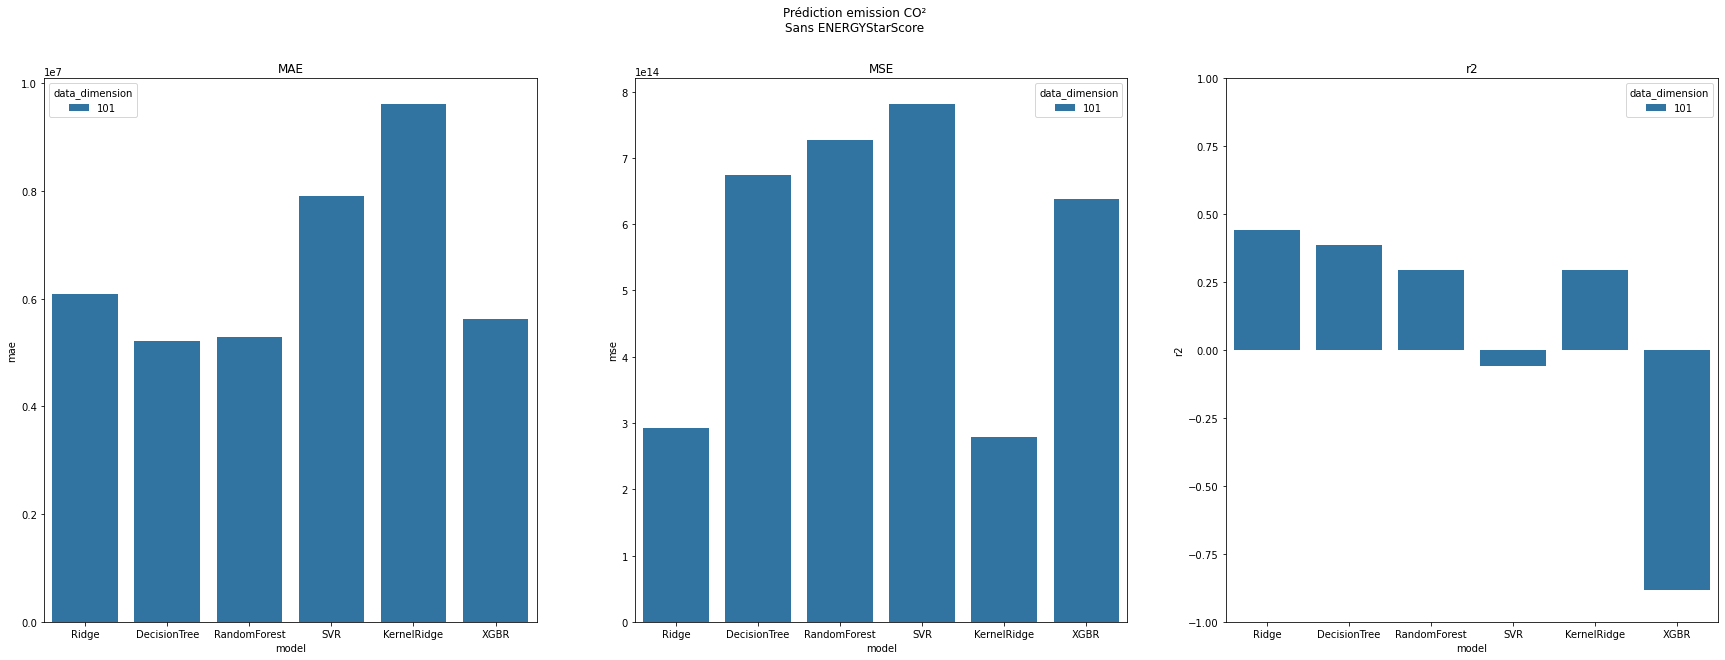

In [379]:
fig ,ax = plt.subplots(1,3,figsize=(30,10))
plt.suptitle('Prédiction emission CO²\nSans ENERGYStarScore')
g = sn.barplot(x='model',y='mae',hue='data_dimension',data=comparative_co2, ax=ax[0]).set(title='MAE')
g = sn.barplot(x='model',y='mse',hue='data_dimension',data=comparative_co2, ax=ax[1]).set(title="MSE")
g = sn.barplot(x='model',y='r2',hue='data_dimension',data=comparative_co2, ax=ax[2]).set(title="r2", ylim=(-1,1))

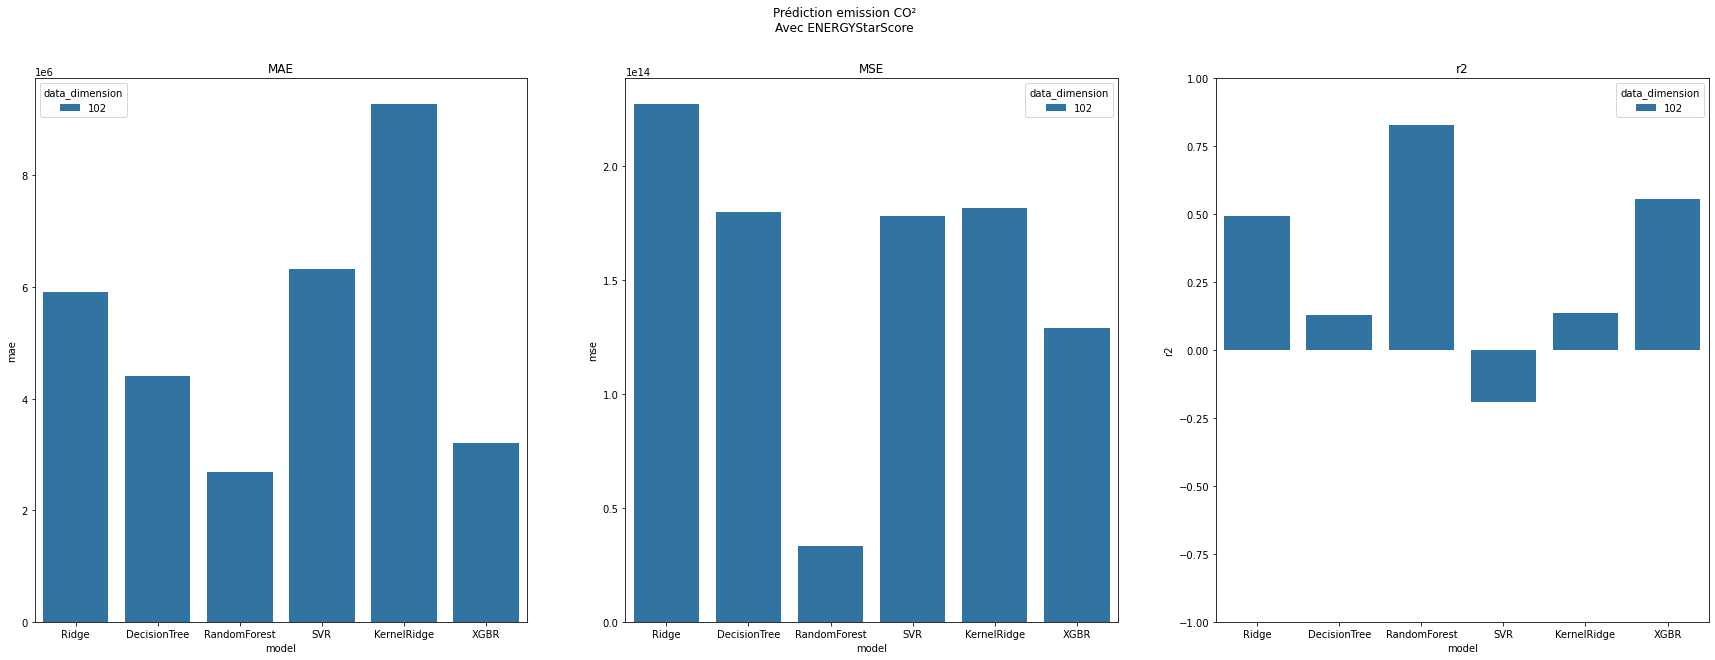

In [380]:
fig ,ax = plt.subplots(1,3,figsize=(30,10))
plt.suptitle('Prédiction emission CO²\nAvec ENERGYStarScore')
g = sn.barplot(x='model',y='mae',hue='data_dimension',data=comparative_co2_ess, ax=ax[0]).set(title='MAE')
g = sn.barplot(x='model',y='mse',hue='data_dimension',data=comparative_co2_ess, ax=ax[1]).set(title="MSE")
g = sn.barplot(x='model',y='r2',hue='data_dimension',data=comparative_co2_ess, ax=ax[2]).set(title="r2", ylim=(-1,1))

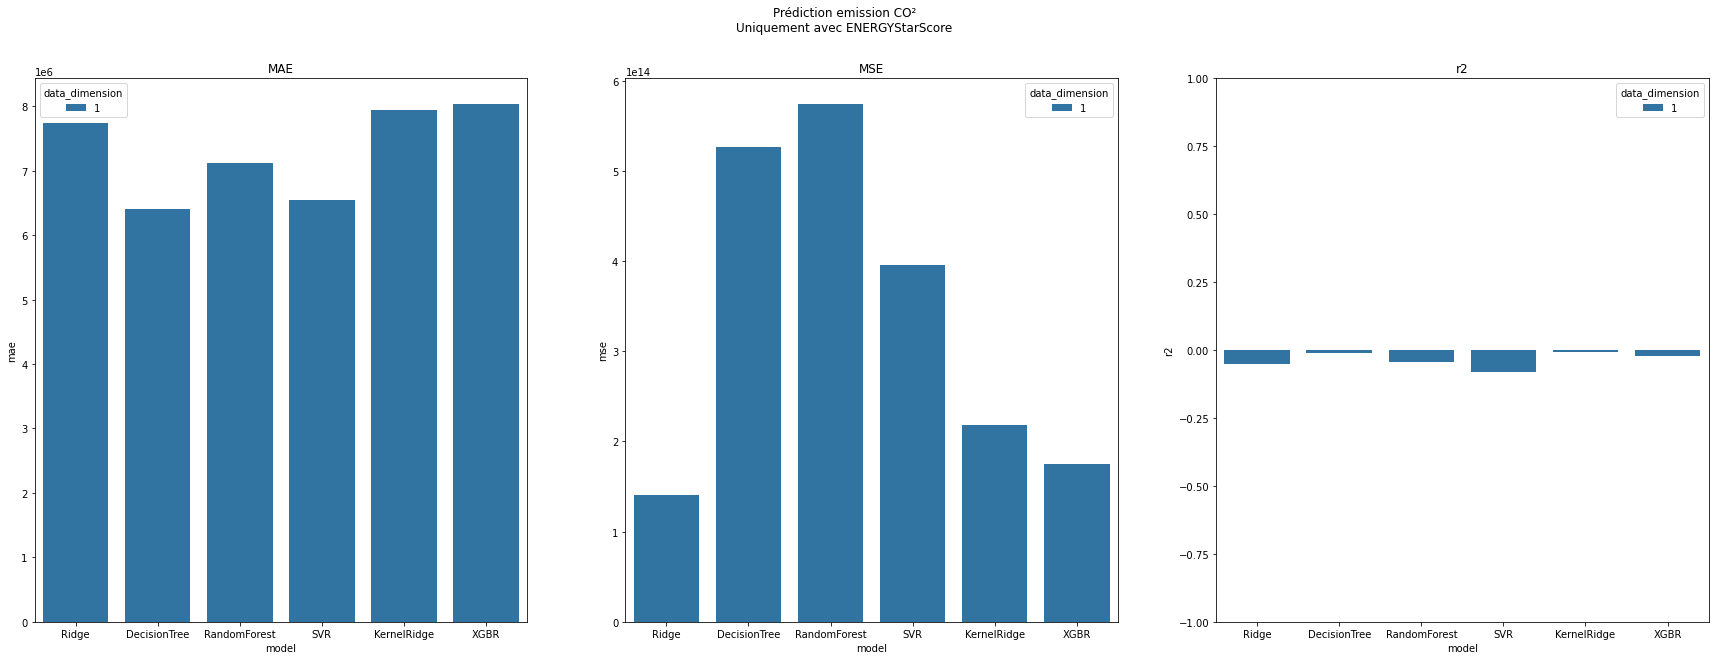

In [381]:
fig ,ax = plt.subplots(1,3,figsize=(30,10))
plt.suptitle('Prédiction emission CO²\nUniquement avec ENERGYStarScore')
g = sn.barplot(x='model',y='mae',hue='data_dimension',data=comparative_co2_ess2, ax=ax[0]).set(title='MAE')
g = sn.barplot(x='model',y='mse',hue='data_dimension',data=comparative_co2_ess2, ax=ax[1]).set(title="MSE")
g = sn.barplot(x='model',y='r2',hue='data_dimension',data=comparative_co2_ess2, ax=ax[2]).set(title="r2", ylim=(-1,1))

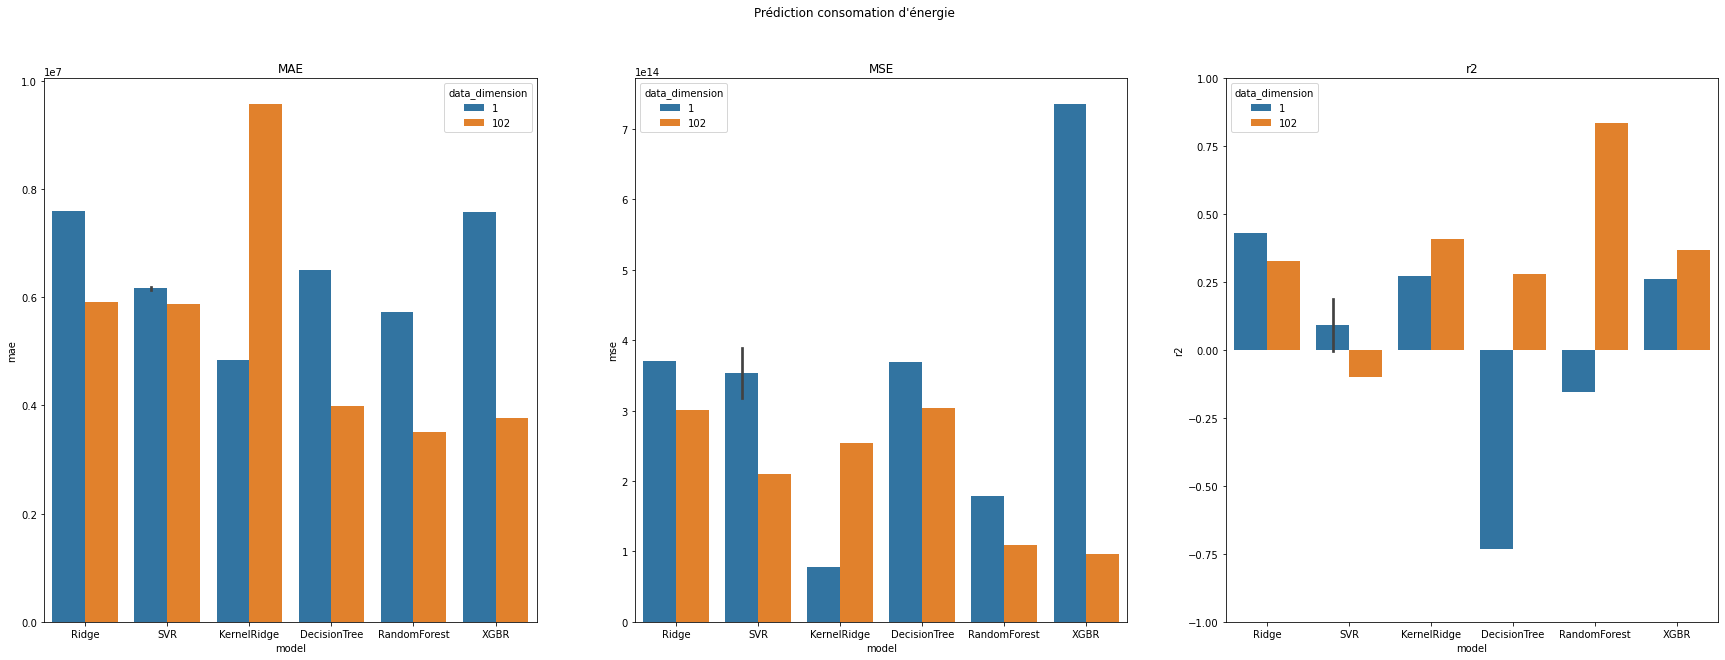

In [382]:
fig ,ax = plt.subplots(1,3,figsize=(30,10))
plt.suptitle('Prédiction consomation d\'énergie')
g = sn.barplot(x='model',y='mae',hue='data_dimension',data=comparative_ele, ax=ax[0]).set(title='MAE')
g = sn.barplot(x='model',y='mse',hue='data_dimension',data=comparative_ele, ax=ax[1]).set(title="MSE")
g = sn.barplot(x='model',y='r2',hue='data_dimension',data=comparative_ele, ax=ax[2]).set(title="r2", ylim=(-1,1))

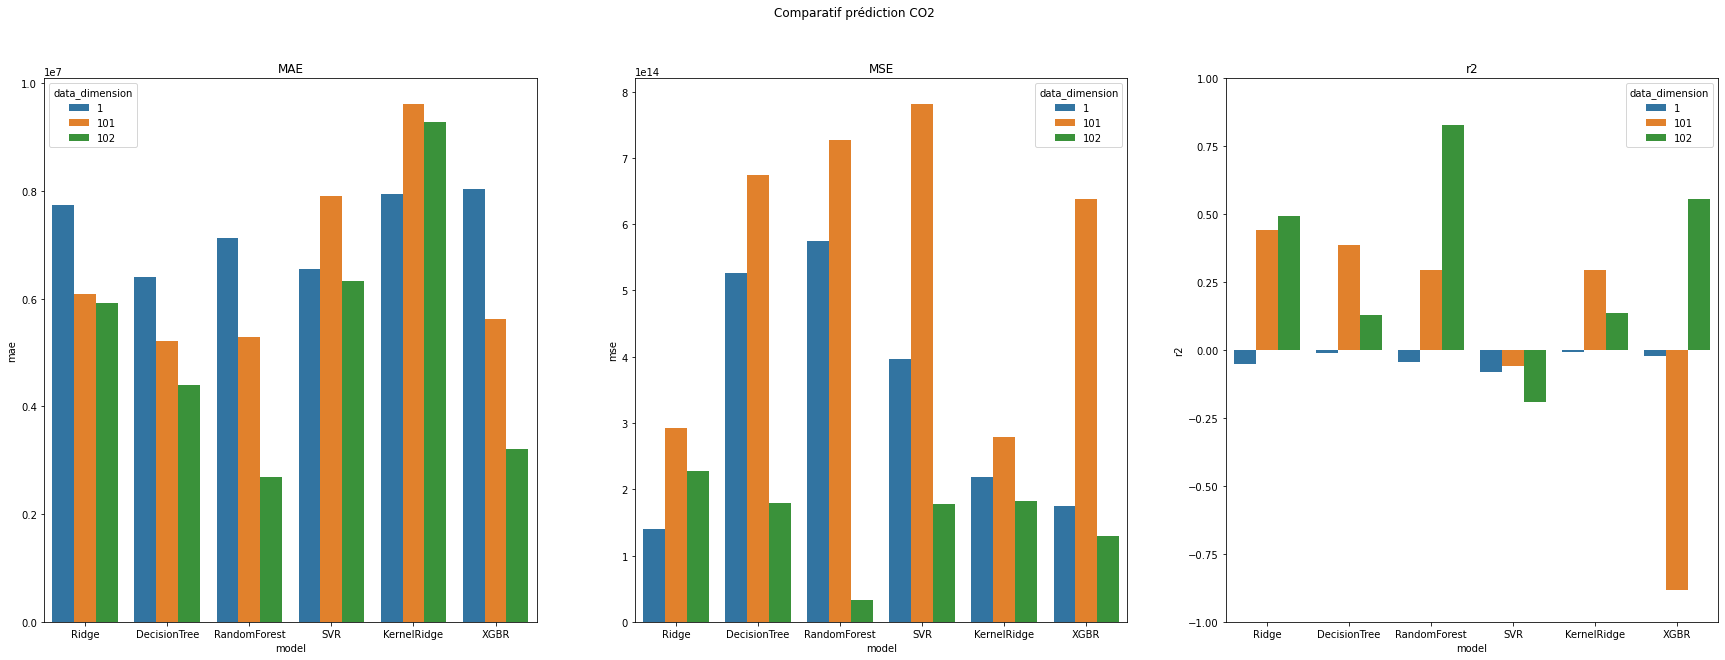

In [383]:
fig ,ax = plt.subplots(1,3,figsize=(30,10))

co2_results = pd.concat([comparative_co2_ess,comparative_co2_ess2,comparative_co2_ess,comparative_co2])


plt.suptitle('Comparatif prédiction CO2')
g = sn.barplot(x='model',y='mae',hue='data_dimension',data=co2_results, ax=ax[0]).set(title='MAE')
g = sn.barplot(x='model',y='mse',hue='data_dimension',data=co2_results, ax=ax[1]).set(title="MSE")
g = sn.barplot(x='model',y='r2',hue='data_dimension', data=co2_results, ax=ax[2]).set(title="r2", ylim=(-1,1))


Dans l'ensemble, l'Energy Star Score permet d'améliorer la qualité des modèles pour la prédiction des émissions de CO². De ce fait et au vu des résultats ci-dessus, pour prédire les quantités de CO² émisent et aussi la quantité d'énergie consommée nous allons choisir l'algorithme de régression Random Forest.